In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_traffic_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    drop_null_rows,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [5]:
def encode_holiday(dataframe):
    dataframe["holiday"] = dataframe["holiday"].apply(lambda x: 1 if x != "None" else 0)
    return dataframe


dataframe = (
    load_traffic_data()
    .pipe(format_datetime, col="date_time")
    .pipe(set_index, col="date_time")
    .pipe(
        select_column,
        cols=[
            "holiday",
            "temp",
            "rain_1h",
            "snow_1h",
            "clouds_all",
            "traffic_volume",
        ],
    )
    .pipe(encode_holiday)
    .pipe(fill_missing_dates, freq="H")
    .pipe(resample_Data, freq="3H")
    # .pipe(replace_null)
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (48204, 9)
set_index: DF Shape (48204, 8)
select_column: DF Shape (48204, 6)
fill_missing_dates: DF Shape (52551, 6)
resample_Data: DF Shape (17517, 6)
dataframe shape (17517, 6)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17517 entries, 2012-10-02 09:00:00 to 2018-09-30 21:00:00
Freq: 3H
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         17517 non-null  float64
 1   temp            17517 non-null  float64
 2   rain_1h         17517 non-null  float64
 3   snow_1h         17517 non-null  float64
 4   clouds_all      17517 non-null  float64
 5   traffic_volume  17517 non-null  float64
dtypes: float64(6)
memory usage: 958.0 KB
None


,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,,
2012-10-02 09:00:00,0.0,289.073333,0.0,0.0,68.333333,4942.666667
2012-10-02 12:00:00,0.0,290.996667,0.0,0.0,55.333333,5041.666667
2012-10-02 15:00:00,0.0,293.723333,0.0,0.0,7.333333,5796.666667
2012-10-02 18:00:00,0.0,291.150000,0.0,0.0,13.666667,3697.666667
2012-10-02 21:00:00,0.0,287.073333,0.0,0.0,1.000000,1617.666667


In [6]:
dataframe = dataframe[-1825:].copy()
dataframe.isna().sum()

holiday           0
temp              0
rain_1h           0
snow_1h           0
clouds_all        0
traffic_volume    0
dtype: int64

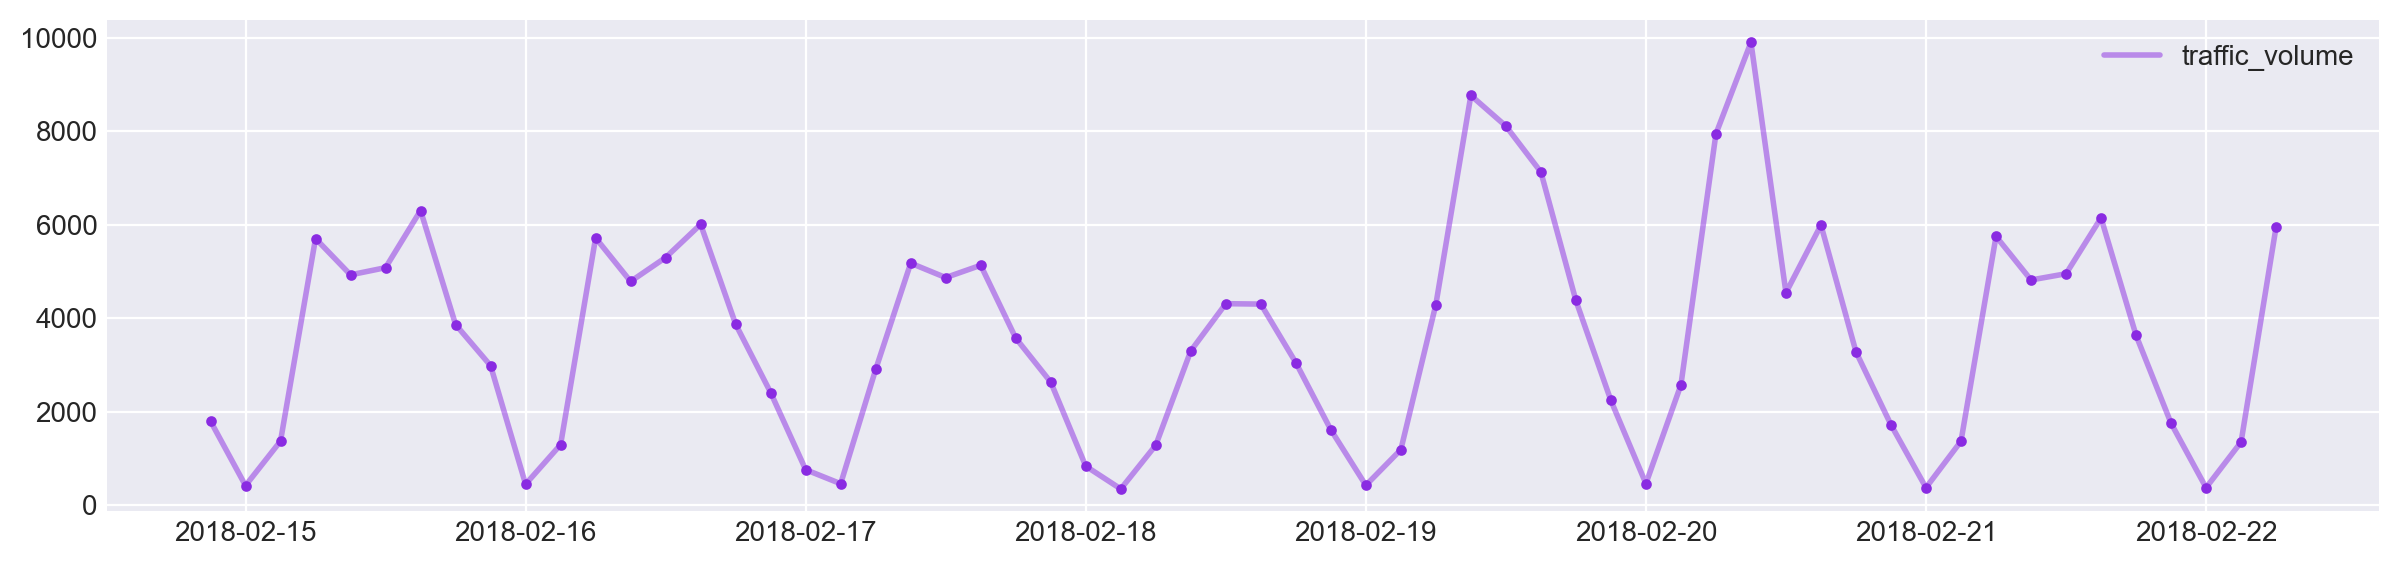

In [7]:
show_dataset(dataframe[:60], columns=["traffic_volume"])

In [8]:
DT_FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
CYCLIC_FEATURE = ["day", "month", "year"]
LAGS = [1, 2]
FEATURE_WINDOW_LEN = 3

TARGET_COLUMN = "traffic_volume"
TEST_SIZE = 30

In [9]:
print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

train_data, test_data = test_train_split(df_feat, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ", end="\n\n")

train_x, train_y = seperate_target(train_data, TARGET_COLUMN)
test_x, test_y = seperate_target(test_data, TARGET_COLUMN)

print(f"train_x shape after seperate_target {train_x.shape}")
print(f"train_y shape after seperate_target {train_y.shape}")
print(f"test_x  shape after seperate_target {test_x.shape}")
print(f"test_y  shape after seperate_target {test_y.shape}")

dataframe shape (1825, 6)
dataframe shape after Feature Union (1822, 25)

Train Size after Test_Train Split: (1792, 25)
Test  Size after Test_Train Split: (30, 25) 

train_x shape after seperate_target (1792, 24)
train_y shape after seperate_target (1792, 1)
test_x  shape after seperate_target (30, 24)
test_y  shape after seperate_target (30, 1)


In [10]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.013 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.329 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.385 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.193 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.368 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.450 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.209 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.379 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.499 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.240 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.373 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

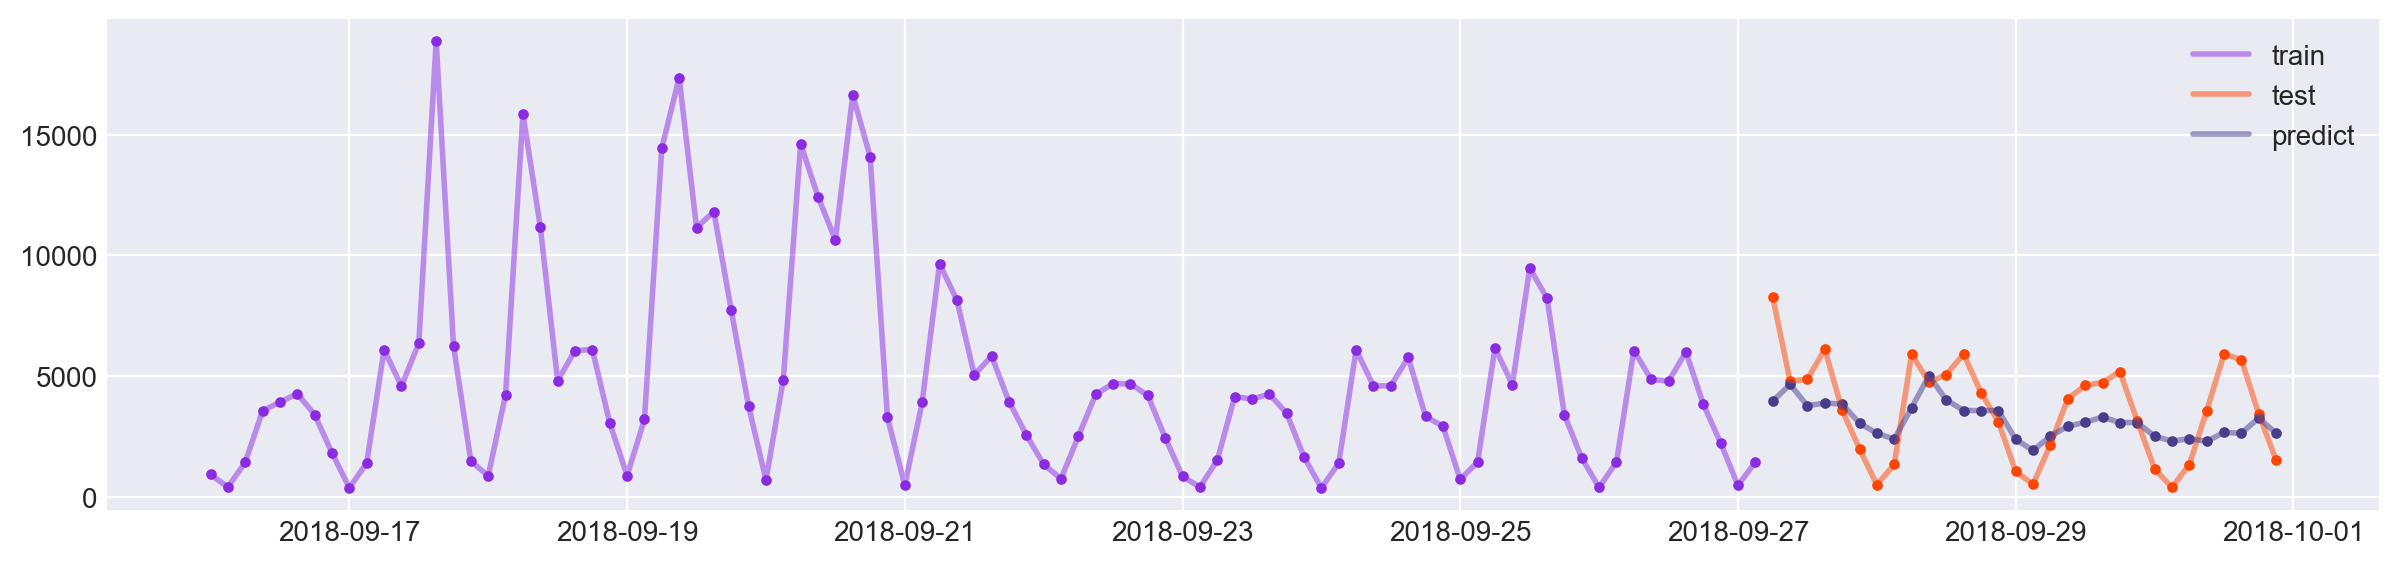

In [13]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [14]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  9  iterations


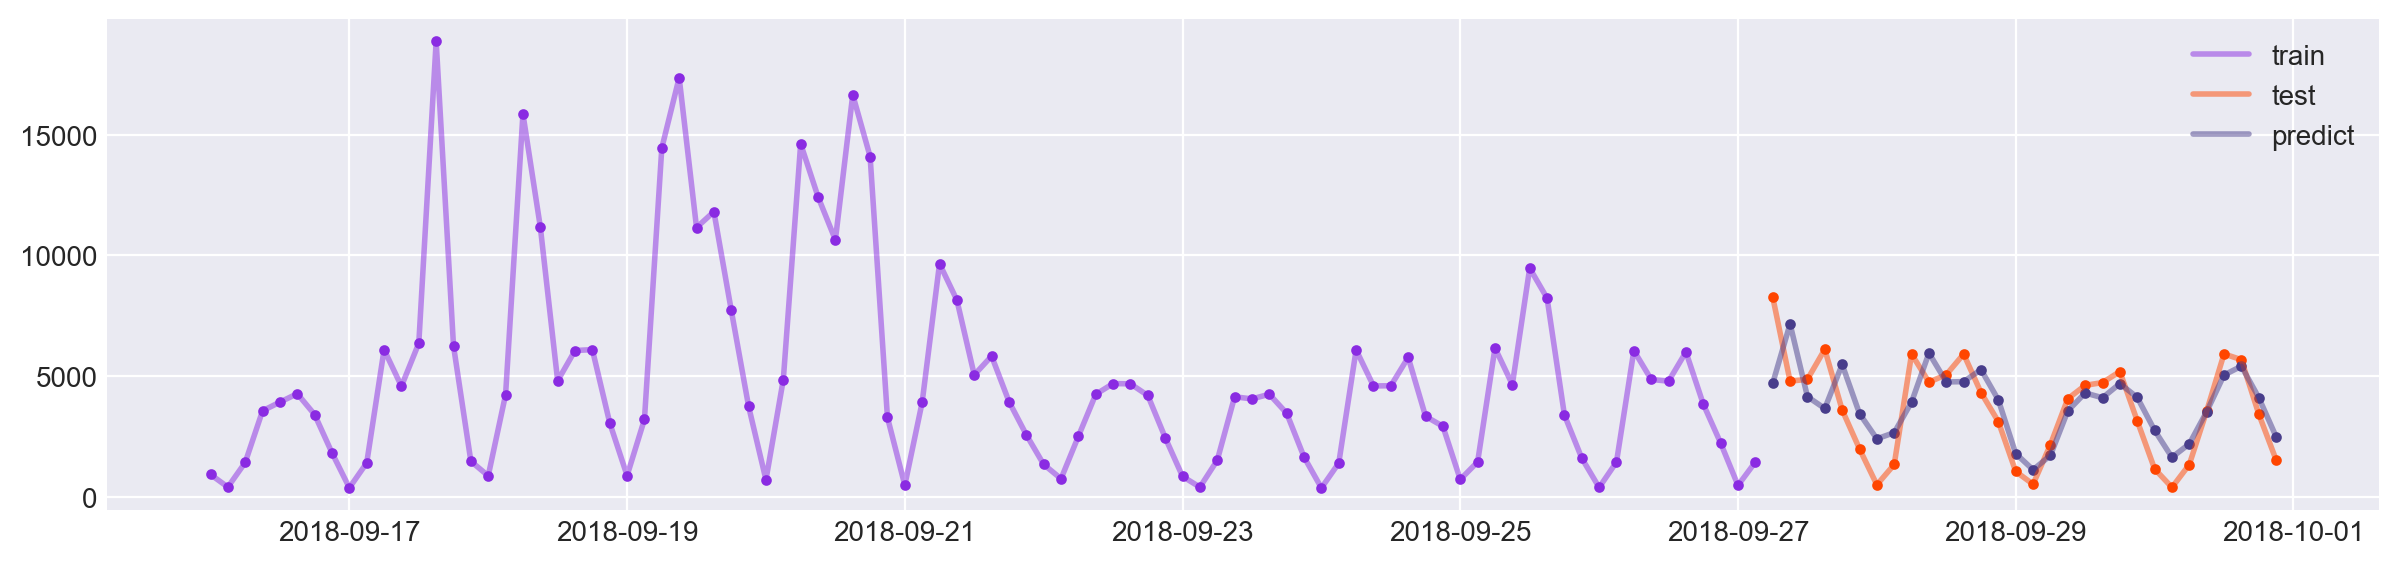

In [15]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [17]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", LassoCV(max_iter=10000, fit_intercept=True)),
    ]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

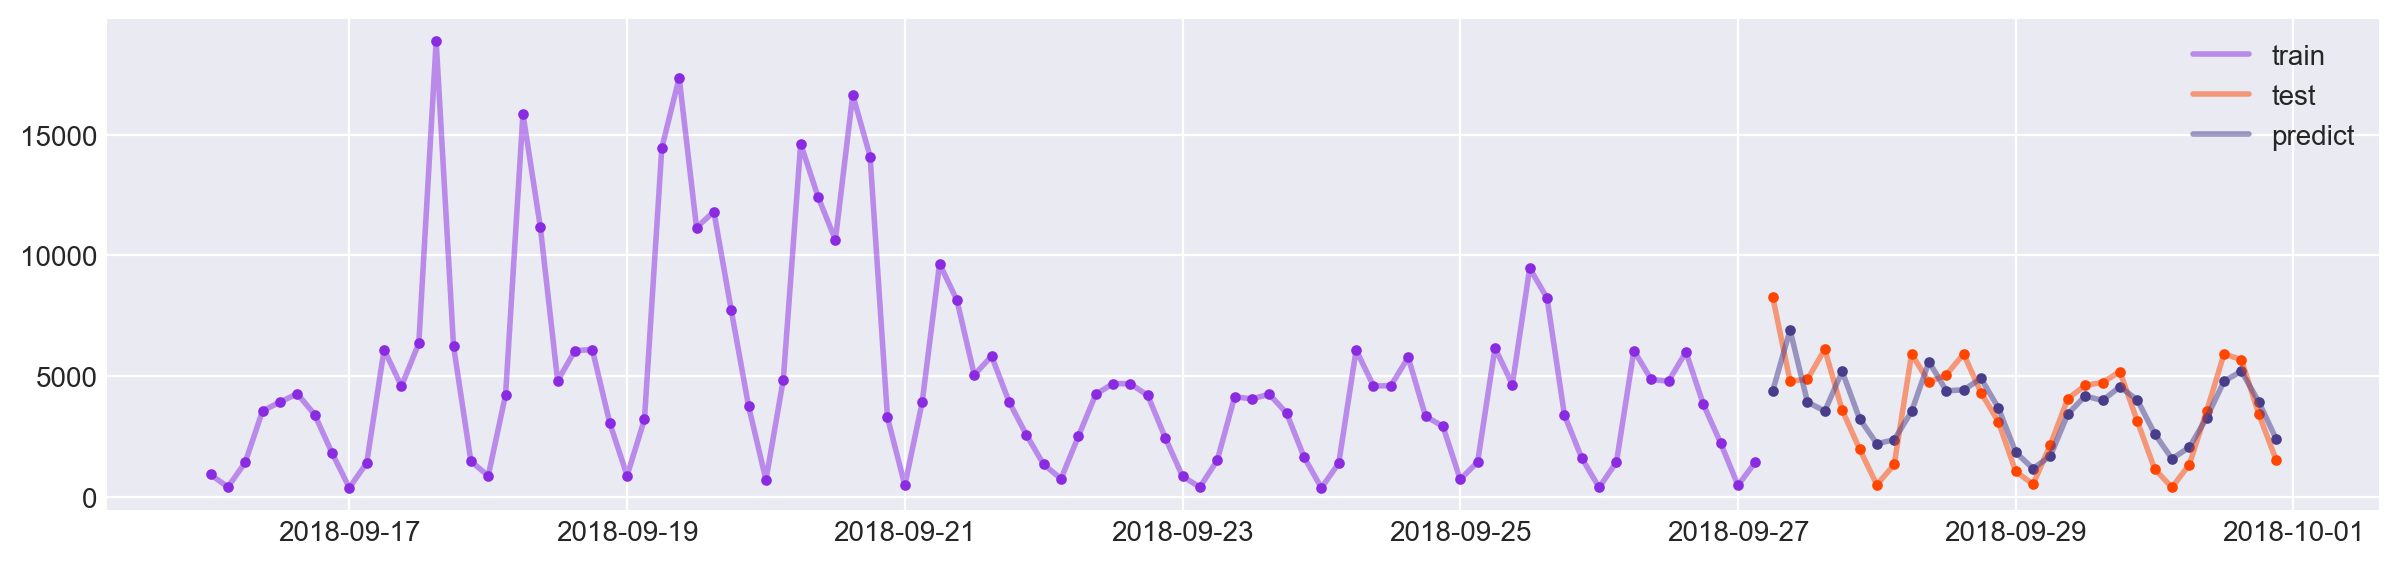

In [18]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# best Params {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 600}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [3],
    "min_samples_split": [7],
    "n_estimators": [600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.734 total time=   4.2s
[CV 2/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.826 total time=   8.5s
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.808 total time=  13.0s
0.7889543918400479 {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 600}


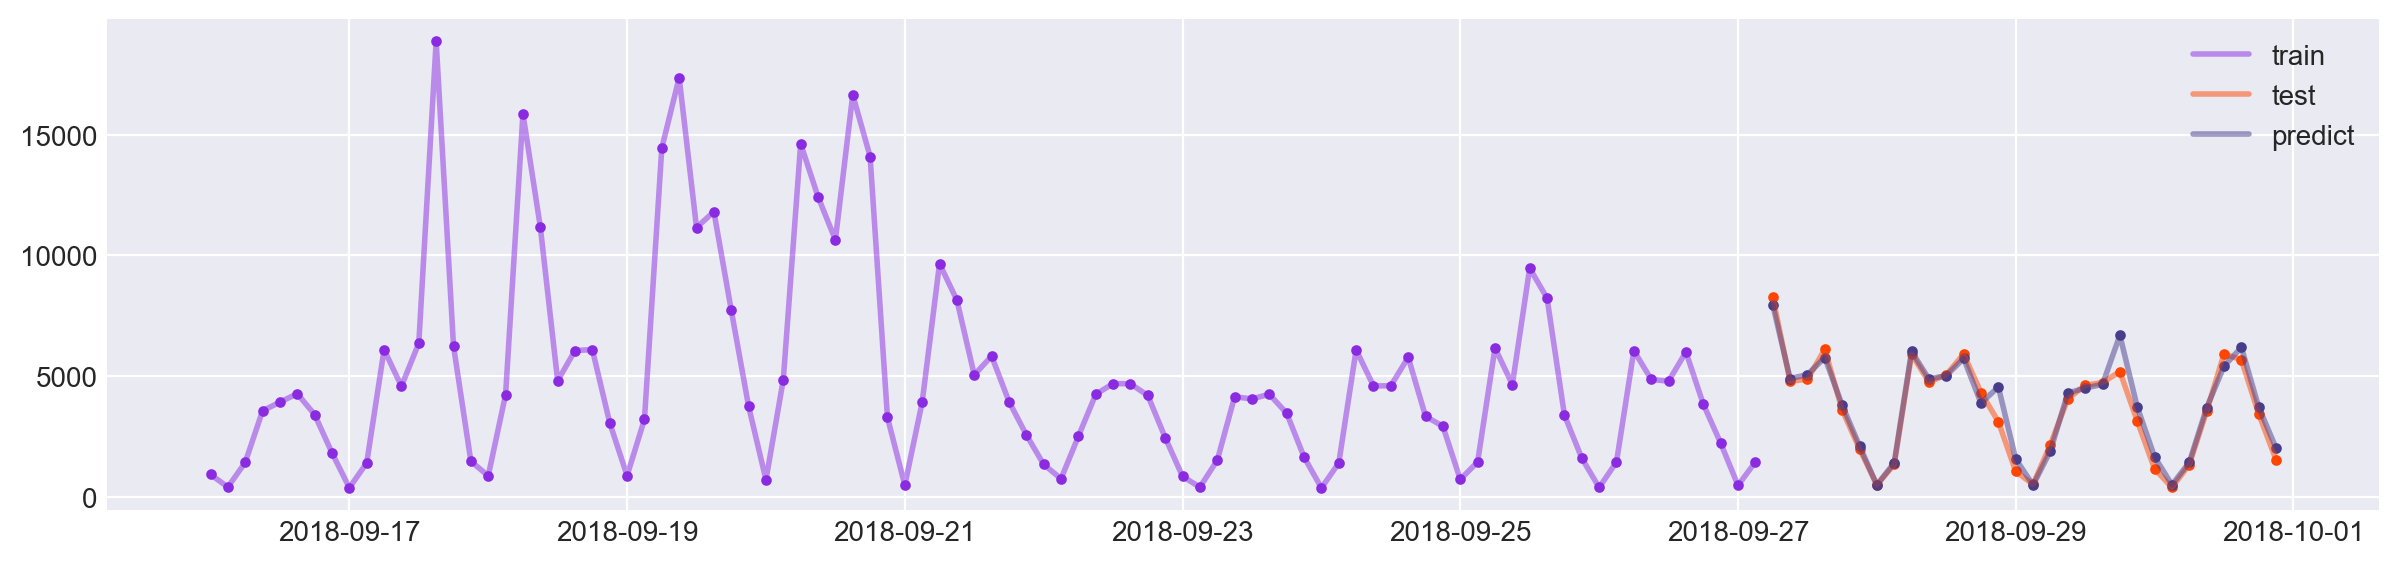

In [21]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:3986.60351	validation_1-mae:3587.10426
[1]	validation_0-mae:3947.59730	validation_1-mae:3549.70604
[2]	validation_0-mae:3909.00170	validation_1-mae:3512.44308
[3]	validation_0-mae:3870.78636	validation_1-mae:3475.56770
[4]	validation_0-mae:3832.96430	validation_1-mae:3439.03042
[5]	validation_0-mae:3795.49193	validation_1-mae:3402.94681
[6]	validation_0-mae:3758.41874	validation_1-mae:3367.12787
[7]	validation_0-mae:3721.65327	validation_1-mae:3331.88569
[8]	validation_0-mae:3685.30655	validation_1-mae:3296.87532
[9]	validation_0-mae:3649.31946	validation_1-mae:3262.25478
[10]	validation_0-mae:3613.68029	validation_1-mae:3227.93120
[11]	validation_0-mae:3578.35532	validation_1-mae:3194.03207
[12]	validation_0-mae:3543.41046	validation_1-mae:3160.42106
[13]	validation_0-mae:3508.80595	validation_1-mae:3127.18991
[14]	validation_0-mae:3474.53670	validation_1-mae:3094.20292
[15]	validation_0-mae:3440.61502	validation_1-mae:3061.42883
[16]	validation_0-mae:3407.06863	v

[134]	validation_0-mae:1137.94951	validation_1-mae:901.53607
[135]	validation_0-mae:1128.29785	validation_1-mae:893.46521
[136]	validation_0-mae:1118.63149	validation_1-mae:885.73011
[137]	validation_0-mae:1109.12249	validation_1-mae:878.54752
[138]	validation_0-mae:1099.71012	validation_1-mae:870.96098
[139]	validation_0-mae:1090.33964	validation_1-mae:863.53522
[140]	validation_0-mae:1081.11396	validation_1-mae:856.08180
[141]	validation_0-mae:1071.98092	validation_1-mae:848.90042
[142]	validation_0-mae:1063.09561	validation_1-mae:841.20710
[143]	validation_0-mae:1054.13596	validation_1-mae:834.45443
[144]	validation_0-mae:1045.43365	validation_1-mae:827.44119
[145]	validation_0-mae:1036.76215	validation_1-mae:821.44226
[146]	validation_0-mae:1028.23496	validation_1-mae:815.64908
[147]	validation_0-mae:1019.76442	validation_1-mae:810.05081
[148]	validation_0-mae:1011.33501	validation_1-mae:804.52022
[149]	validation_0-mae:1003.03648	validation_1-mae:799.43808
[150]	validation_0-mae:9

[271]	validation_0-mae:451.41239	validation_1-mae:452.32361
[272]	validation_0-mae:449.31551	validation_1-mae:451.04640
[273]	validation_0-mae:447.26550	validation_1-mae:449.43779
[274]	validation_0-mae:445.08926	validation_1-mae:448.38920
[275]	validation_0-mae:442.93578	validation_1-mae:447.49496
[276]	validation_0-mae:441.06939	validation_1-mae:446.29203
[277]	validation_0-mae:439.13518	validation_1-mae:445.07555
[278]	validation_0-mae:437.22191	validation_1-mae:443.44728
[279]	validation_0-mae:435.14864	validation_1-mae:442.28218
[280]	validation_0-mae:433.32131	validation_1-mae:441.14492
[281]	validation_0-mae:431.50192	validation_1-mae:439.73795
[282]	validation_0-mae:429.44687	validation_1-mae:438.72456
[283]	validation_0-mae:427.70445	validation_1-mae:437.52826
[284]	validation_0-mae:425.70962	validation_1-mae:436.77917
[285]	validation_0-mae:424.00079	validation_1-mae:435.60183
[286]	validation_0-mae:422.33092	validation_1-mae:434.43552
[287]	validation_0-mae:420.30768	validat

[408]	validation_0-mae:305.49292	validation_1-mae:369.56162
[409]	validation_0-mae:304.92058	validation_1-mae:369.61141
[410]	validation_0-mae:304.43862	validation_1-mae:369.38802
[411]	validation_0-mae:303.83303	validation_1-mae:368.89482
[412]	validation_0-mae:303.22896	validation_1-mae:368.94344
[413]	validation_0-mae:302.76360	validation_1-mae:368.79216
[414]	validation_0-mae:302.17342	validation_1-mae:368.30378
[415]	validation_0-mae:301.59210	validation_1-mae:368.35087
[416]	validation_0-mae:301.01909	validation_1-mae:367.80434
[417]	validation_0-mae:300.45306	validation_1-mae:367.37275
[418]	validation_0-mae:299.92850	validation_1-mae:367.39742
[419]	validation_0-mae:299.40870	validation_1-mae:367.07126
[420]	validation_0-mae:298.89670	validation_1-mae:366.83085
[421]	validation_0-mae:298.36290	validation_1-mae:366.48821
[422]	validation_0-mae:297.92043	validation_1-mae:366.56260
[423]	validation_0-mae:297.49805	validation_1-mae:366.63623
[424]	validation_0-mae:296.96466	validat

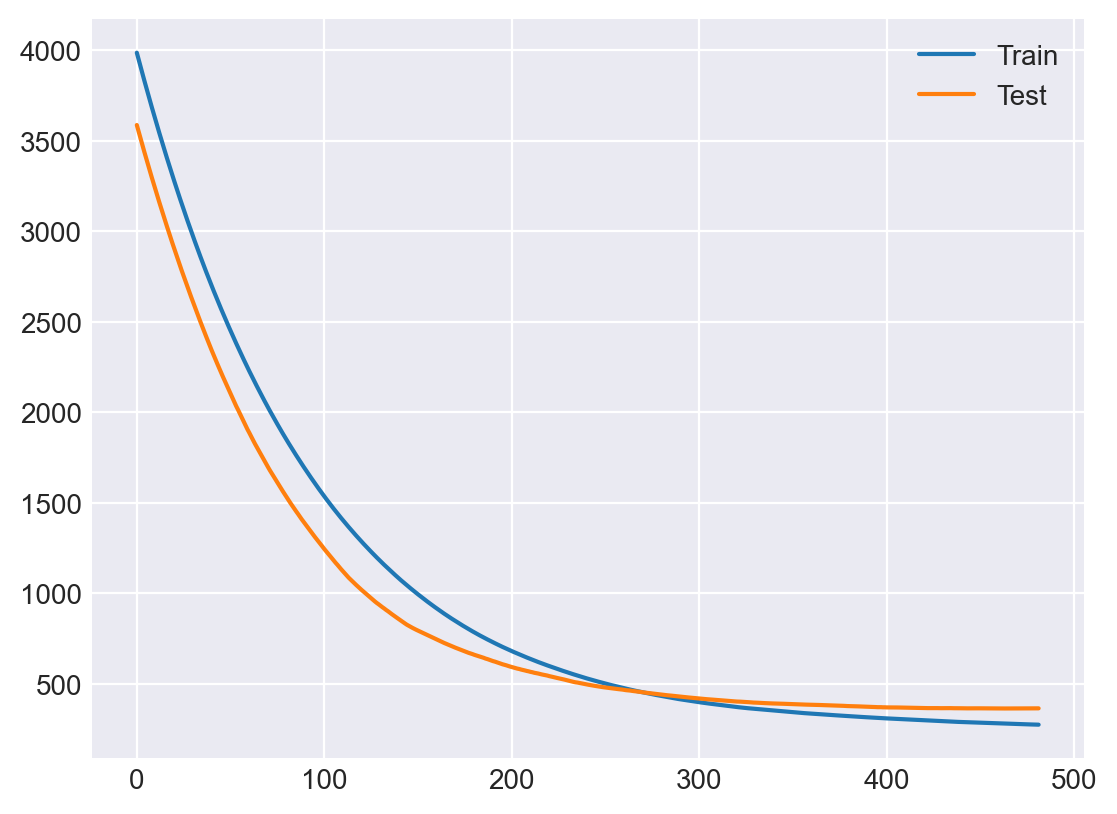

In [22]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

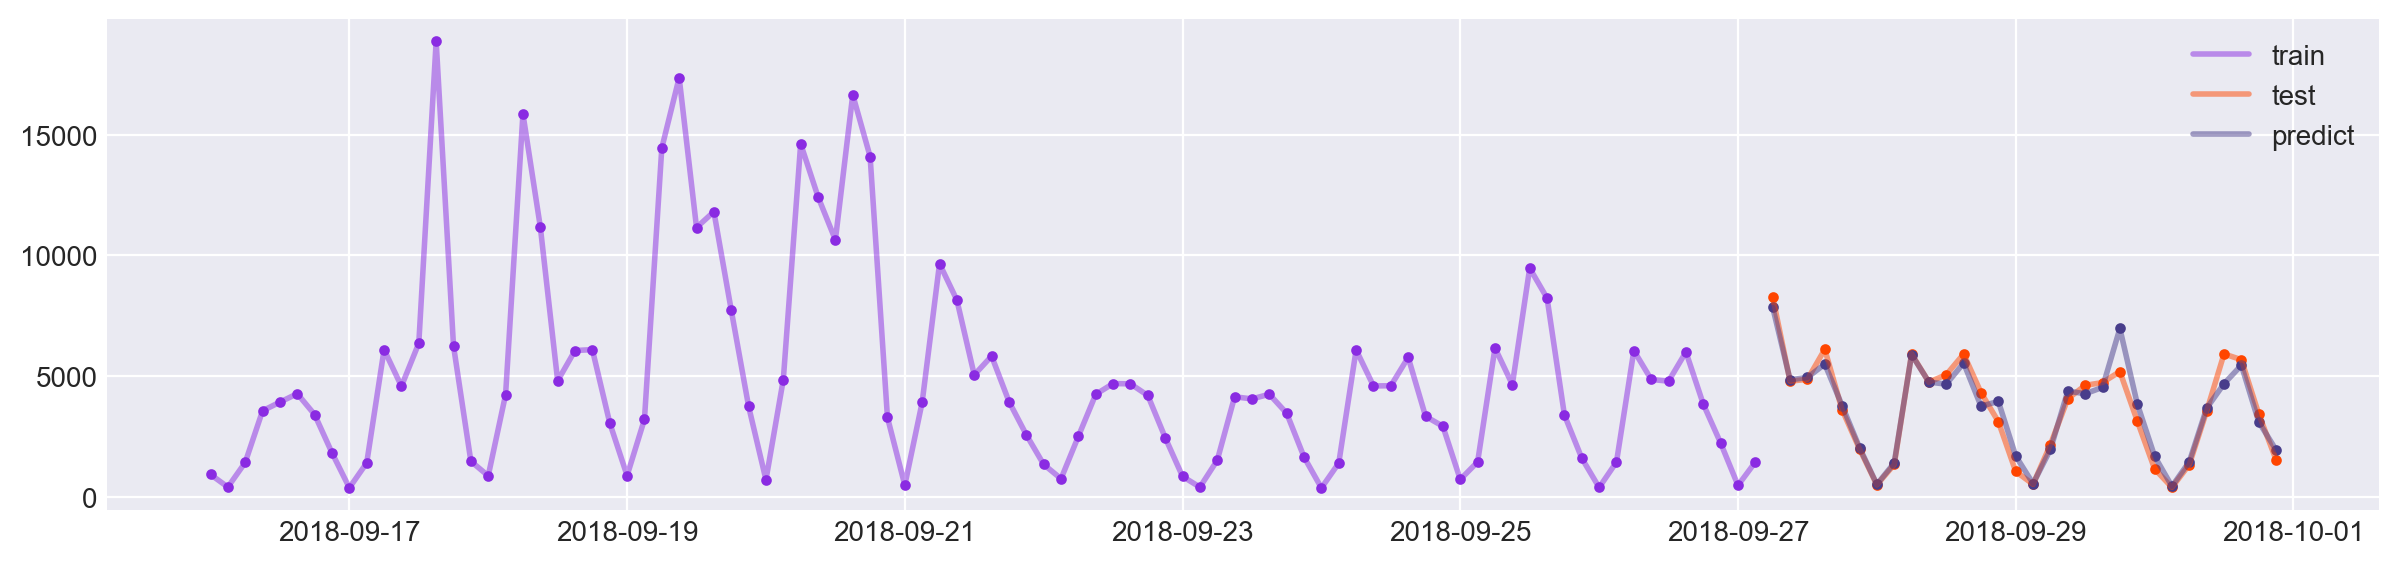

In [23]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [24]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 100000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 1943.48	training's l2: 6.77225e+06	valid_1's l1: 1567.43	valid_1's l2: 3.53941e+06
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 1782.7	training's l2: 5.747e+06	valid_1's l1: 1428.39	valid_1's l2: 2.95466e+06
[3]	training's l1: 1640.3	training's l2: 4.91579e+06	valid_1's l1: 1303.72	valid_1's l2: 2.47107e+06
[4]	training's l1: 1512.36	training's l2: 4.23544e+06	valid_1's l1: 1199.27	valid_1's l2: 2.08757e+06
[5]	training's l1: 1398.86	training's l2: 3.67636e+06	valid_1's l1: 1108.95	valid_1's l2: 1.75438e+06
[6]	training's l1: 1296.07	training's l2: 3.21107e+06	valid_1's l1: 1035.17	valid_1's l2: 1.51081e+06
[7]	training's l1: 1204.06	training's l2: 2.81865e+06	valid_1's l1: 971.495	valid_1's l2: 1.31849e+06
[8]	training's l1: 1122.94	training's l2: 2.5003e+06	valid_1's l1: 908.195	valid_1's l2: 1.143e+06
[9]	training's l1: 1045.69	training's l2: 2.23216e+06	valid_1's l1: 841.708	valid_1's l2: 991892
[10]	training's l1: 979.571	tra

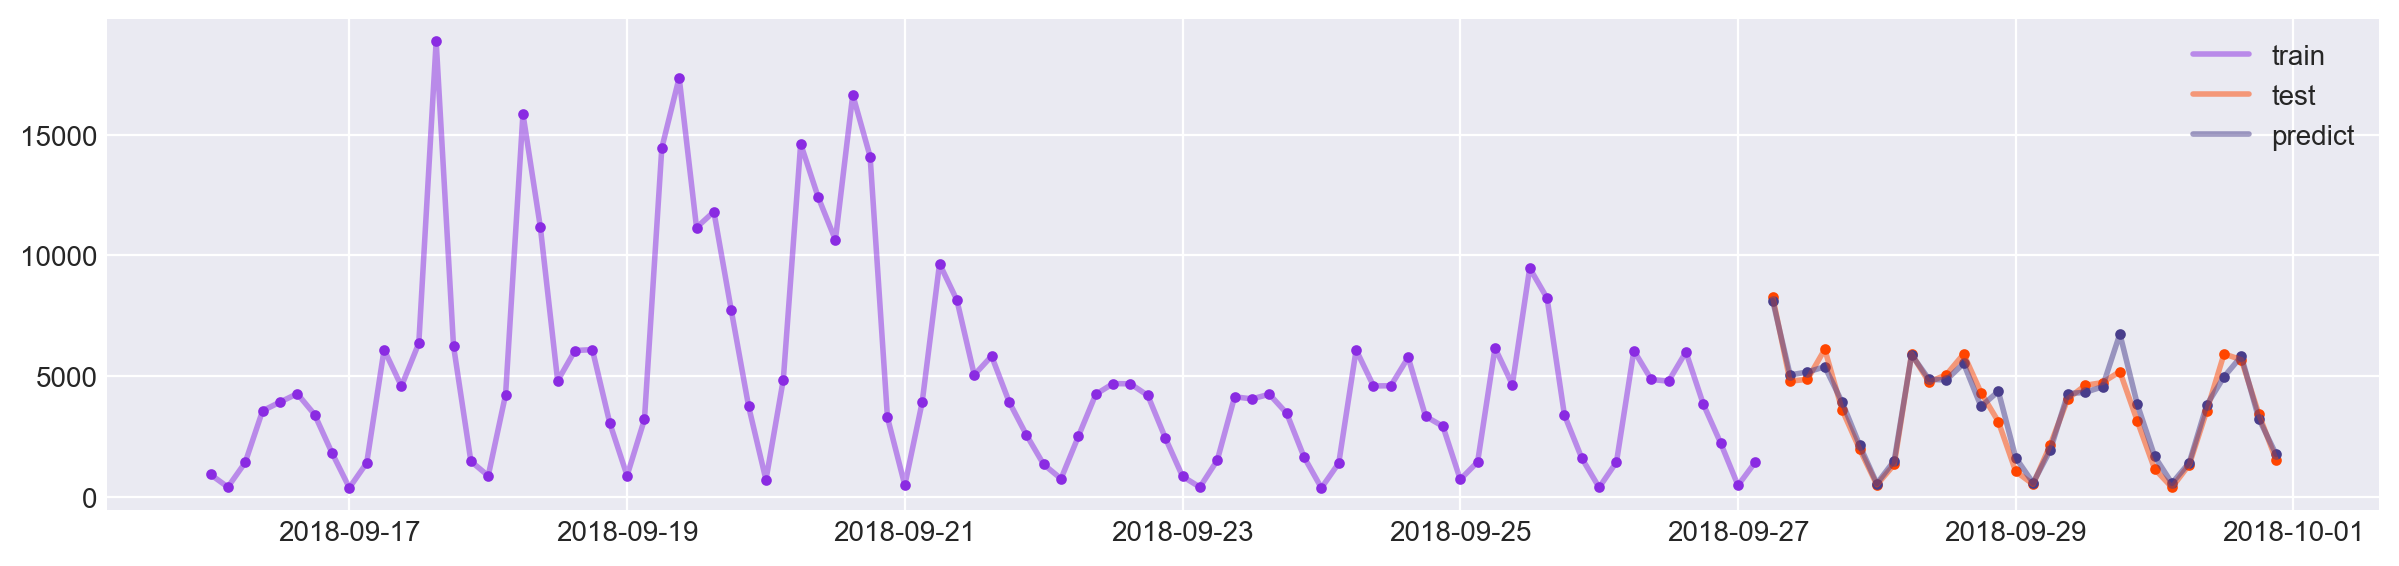

In [25]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [26]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 4351.9179700	test: 5393.7059427	best: 5393.7059427 (0)	total: 171ms	remaining: 2m 51s
1:	learn: 4036.0763916	test: 5061.1635501	best: 5061.1635501 (1)	total: 174ms	remaining: 1m 27s
2:	learn: 3728.2684823	test: 4764.9905067	best: 4764.9905067 (2)	total: 177ms	remaining: 59s
3:	learn: 3511.6727556	test: 4563.8623543	best: 4563.8623543 (3)	total: 179ms	remaining: 44.5s
4:	learn: 3270.6178155	test: 4335.4562842	best: 4335.4562842 (4)	total: 182ms	remaining: 36.2s
5:	learn: 3041.5712865	test: 4098.8438341	best: 4098.8438341 (5)	total: 185ms	remaining: 30.6s
6:	learn: 2826.7062127	test: 3868.1705338	best: 3868.1705338 (6)	total: 189ms	remaining: 26.8s
7:	learn: 2642.6879238	test: 3659.6845977	best: 3659.6845977 (7)	total: 192ms	remaining: 23.8s
8:	learn: 2489.0121034	test: 3493.9598221	best: 3493.9598221 (8)	total: 195ms	remaining: 21.5s
9:	learn: 2382.0912903	test: 3387.9239812	best: 3387.9239812 (9)	total: 198ms	remaining: 19.6s
10:	learn: 2256.3586972	test: 3269.4910164	best: 3

94:	learn: 884.3067539	test: 1580.2300279	best: 1578.2395137 (92)	total: 1s	remaining: 9.54s
95:	learn: 876.6710938	test: 1575.8016580	best: 1575.8016580 (95)	total: 1.03s	remaining: 9.69s
96:	learn: 873.7068712	test: 1573.6358517	best: 1573.6358517 (96)	total: 1.04s	remaining: 9.69s
97:	learn: 868.2349437	test: 1573.2989392	best: 1573.2989392 (97)	total: 1.05s	remaining: 9.68s
98:	learn: 866.4213857	test: 1573.1523389	best: 1573.1523389 (98)	total: 1.06s	remaining: 9.64s
99:	learn: 858.9852945	test: 1569.6007644	best: 1569.6007644 (99)	total: 1.08s	remaining: 9.75s
100:	learn: 858.1398205	test: 1570.3122802	best: 1569.6007644 (99)	total: 1.11s	remaining: 9.87s
101:	learn: 857.3462133	test: 1569.4224365	best: 1569.4224365 (101)	total: 1.13s	remaining: 9.95s
102:	learn: 852.0760428	test: 1568.2180808	best: 1568.2180808 (102)	total: 1.15s	remaining: 9.97s
103:	learn: 850.4451165	test: 1567.1508306	best: 1567.1508306 (103)	total: 1.15s	remaining: 9.92s
104:	learn: 848.8142381	test: 1566.9

187:	learn: 688.0485674	test: 1546.1183260	best: 1535.1591799 (168)	total: 2.08s	remaining: 9s
188:	learn: 687.1133899	test: 1547.3064977	best: 1535.1591799 (168)	total: 2.11s	remaining: 9.06s
189:	learn: 686.4440185	test: 1546.7495864	best: 1535.1591799 (168)	total: 2.13s	remaining: 9.11s
190:	learn: 684.0319119	test: 1545.2763202	best: 1535.1591799 (168)	total: 2.15s	remaining: 9.1s
191:	learn: 681.2069780	test: 1545.8608282	best: 1535.1591799 (168)	total: 2.17s	remaining: 9.12s
192:	learn: 680.6146429	test: 1545.4545816	best: 1535.1591799 (168)	total: 2.19s	remaining: 9.17s
193:	learn: 680.2438944	test: 1545.4570625	best: 1535.1591799 (168)	total: 2.22s	remaining: 9.22s
194:	learn: 678.9576066	test: 1544.5679393	best: 1535.1591799 (168)	total: 2.24s	remaining: 9.25s
195:	learn: 676.3346440	test: 1540.5575091	best: 1535.1591799 (168)	total: 2.25s	remaining: 9.24s
196:	learn: 675.5711670	test: 1539.6892444	best: 1535.1591799 (168)	total: 2.27s	remaining: 9.25s
197:	learn: 673.7646758	

280:	learn: 563.2535445	test: 1528.6198350	best: 1527.1732565 (274)	total: 3.15s	remaining: 8.06s
281:	learn: 562.5111754	test: 1528.8796023	best: 1527.1732565 (274)	total: 3.15s	remaining: 8.03s
282:	learn: 562.1280594	test: 1529.3046442	best: 1527.1732565 (274)	total: 3.15s	remaining: 8s
283:	learn: 561.1913405	test: 1522.1985103	best: 1522.1985103 (283)	total: 3.16s	remaining: 7.96s
284:	learn: 560.3574098	test: 1520.8540992	best: 1520.8540992 (284)	total: 3.16s	remaining: 7.93s
285:	learn: 559.6078831	test: 1520.9959948	best: 1520.8540992 (284)	total: 3.16s	remaining: 7.89s
286:	learn: 557.9032249	test: 1522.0169914	best: 1520.8540992 (284)	total: 3.16s	remaining: 7.86s
287:	learn: 556.1611176	test: 1520.7541562	best: 1520.7541562 (287)	total: 3.17s	remaining: 7.83s
288:	learn: 553.3325673	test: 1519.6660365	best: 1519.6660365 (288)	total: 3.19s	remaining: 7.86s
289:	learn: 552.3911559	test: 1518.6363726	best: 1518.6363726 (289)	total: 3.22s	remaining: 7.89s
290:	learn: 551.1505783

376:	learn: 480.2239533	test: 1510.2424252	best: 1507.2879940 (317)	total: 4.23s	remaining: 7s
377:	learn: 479.4703991	test: 1509.3690682	best: 1507.2879940 (317)	total: 4.26s	remaining: 7.02s
378:	learn: 479.3869943	test: 1509.8278622	best: 1507.2879940 (317)	total: 4.29s	remaining: 7.03s
379:	learn: 478.7194601	test: 1510.2270283	best: 1507.2879940 (317)	total: 4.3s	remaining: 7.03s
380:	learn: 477.2175722	test: 1509.1591814	best: 1507.2879940 (317)	total: 4.32s	remaining: 7.02s
381:	learn: 476.4531596	test: 1509.3621001	best: 1507.2879940 (317)	total: 4.33s	remaining: 7.01s
382:	learn: 476.1063309	test: 1509.4093257	best: 1507.2879940 (317)	total: 4.34s	remaining: 6.99s
383:	learn: 475.6316860	test: 1509.6832990	best: 1507.2879940 (317)	total: 4.35s	remaining: 6.97s
384:	learn: 475.2470220	test: 1509.4160142	best: 1507.2879940 (317)	total: 4.36s	remaining: 6.97s
385:	learn: 474.6429316	test: 1509.1083459	best: 1507.2879940 (317)	total: 4.39s	remaining: 6.98s
386:	learn: 473.9227710	

462:	learn: 419.0263989	test: 1510.4851683	best: 1505.8847617 (444)	total: 5.57s	remaining: 6.46s
463:	learn: 418.5432372	test: 1510.8970259	best: 1505.8847617 (444)	total: 5.59s	remaining: 6.46s
464:	learn: 417.2210240	test: 1511.3408871	best: 1505.8847617 (444)	total: 5.61s	remaining: 6.46s
465:	learn: 416.6053953	test: 1509.8892383	best: 1505.8847617 (444)	total: 5.62s	remaining: 6.45s
466:	learn: 416.1138998	test: 1510.6295933	best: 1505.8847617 (444)	total: 5.64s	remaining: 6.43s
467:	learn: 415.5256306	test: 1510.6771566	best: 1505.8847617 (444)	total: 5.65s	remaining: 6.42s
468:	learn: 415.2523369	test: 1510.8432442	best: 1505.8847617 (444)	total: 5.67s	remaining: 6.41s
469:	learn: 413.9887265	test: 1510.2550085	best: 1505.8847617 (444)	total: 5.68s	remaining: 6.4s
470:	learn: 412.9762261	test: 1509.7306573	best: 1505.8847617 (444)	total: 5.69s	remaining: 6.39s
471:	learn: 411.7932625	test: 1509.2234028	best: 1505.8847617 (444)	total: 5.71s	remaining: 6.38s
472:	learn: 410.93354

569:	learn: 360.6670229	test: 1510.4047420	best: 1505.8847617 (444)	total: 6.62s	remaining: 5s
570:	learn: 360.2432560	test: 1510.8566510	best: 1505.8847617 (444)	total: 6.62s	remaining: 4.98s
571:	learn: 359.8154735	test: 1511.1343697	best: 1505.8847617 (444)	total: 6.63s	remaining: 4.96s
572:	learn: 359.6681346	test: 1511.0690627	best: 1505.8847617 (444)	total: 6.63s	remaining: 4.94s
573:	learn: 359.0292811	test: 1510.3741353	best: 1505.8847617 (444)	total: 6.63s	remaining: 4.92s
574:	learn: 358.2621314	test: 1510.1922346	best: 1505.8847617 (444)	total: 6.63s	remaining: 4.9s
575:	learn: 357.6026957	test: 1510.2366117	best: 1505.8847617 (444)	total: 6.63s	remaining: 4.88s
576:	learn: 357.4315580	test: 1510.5429590	best: 1505.8847617 (444)	total: 6.64s	remaining: 4.87s
577:	learn: 356.8190172	test: 1510.5189862	best: 1505.8847617 (444)	total: 6.64s	remaining: 4.85s
578:	learn: 356.4555919	test: 1511.0992413	best: 1505.8847617 (444)	total: 6.64s	remaining: 4.83s
579:	learn: 355.9767765	

657:	learn: 322.1827074	test: 1510.4093073	best: 1505.8847617 (444)	total: 7.45s	remaining: 3.87s
658:	learn: 322.0358024	test: 1510.4263064	best: 1505.8847617 (444)	total: 7.45s	remaining: 3.85s
659:	learn: 321.9206495	test: 1510.4251143	best: 1505.8847617 (444)	total: 7.45s	remaining: 3.84s
660:	learn: 321.5026453	test: 1510.1873804	best: 1505.8847617 (444)	total: 7.46s	remaining: 3.82s
661:	learn: 321.0656430	test: 1509.8912716	best: 1505.8847617 (444)	total: 7.47s	remaining: 3.81s
662:	learn: 320.7866012	test: 1509.4960813	best: 1505.8847617 (444)	total: 7.48s	remaining: 3.8s
663:	learn: 320.5479002	test: 1509.5657837	best: 1505.8847617 (444)	total: 7.49s	remaining: 3.79s
664:	learn: 320.3887885	test: 1509.8235138	best: 1505.8847617 (444)	total: 7.5s	remaining: 3.78s
665:	learn: 320.0480834	test: 1510.0147532	best: 1505.8847617 (444)	total: 7.51s	remaining: 3.77s
666:	learn: 319.5412303	test: 1509.8498976	best: 1505.8847617 (444)	total: 7.53s	remaining: 3.76s
667:	learn: 319.019506

756:	learn: 287.3915507	test: 1508.8408807	best: 1505.8847617 (444)	total: 8.92s	remaining: 2.86s
757:	learn: 287.1229437	test: 1509.0442797	best: 1505.8847617 (444)	total: 8.94s	remaining: 2.85s
758:	learn: 286.7641798	test: 1509.0123843	best: 1505.8847617 (444)	total: 8.95s	remaining: 2.84s
759:	learn: 286.5306727	test: 1509.2168496	best: 1505.8847617 (444)	total: 8.96s	remaining: 2.83s
760:	learn: 286.1397658	test: 1509.5356757	best: 1505.8847617 (444)	total: 8.97s	remaining: 2.82s
761:	learn: 285.8706931	test: 1509.4003270	best: 1505.8847617 (444)	total: 8.98s	remaining: 2.81s
762:	learn: 285.6908816	test: 1509.7385588	best: 1505.8847617 (444)	total: 9.01s	remaining: 2.8s
763:	learn: 285.6689059	test: 1509.9206198	best: 1505.8847617 (444)	total: 9.04s	remaining: 2.79s
764:	learn: 285.4540508	test: 1510.8484489	best: 1505.8847617 (444)	total: 9.06s	remaining: 2.78s
765:	learn: 285.0846412	test: 1510.9584594	best: 1505.8847617 (444)	total: 9.08s	remaining: 2.77s
766:	learn: 284.78508

845:	learn: 261.7889296	test: 1506.3830008	best: 1505.8847617 (444)	total: 10.2s	remaining: 1.85s
846:	learn: 261.2293268	test: 1506.2530264	best: 1505.8847617 (444)	total: 10.2s	remaining: 1.84s
847:	learn: 261.0150707	test: 1506.4480531	best: 1505.8847617 (444)	total: 10.2s	remaining: 1.83s
848:	learn: 260.7829031	test: 1506.5095567	best: 1505.8847617 (444)	total: 10.2s	remaining: 1.82s
849:	learn: 260.4641043	test: 1506.3908924	best: 1505.8847617 (444)	total: 10.3s	remaining: 1.81s
850:	learn: 260.2767470	test: 1506.4669003	best: 1505.8847617 (444)	total: 10.3s	remaining: 1.8s
851:	learn: 259.9707834	test: 1506.8437548	best: 1505.8847617 (444)	total: 10.3s	remaining: 1.79s
852:	learn: 259.4222927	test: 1506.6929175	best: 1505.8847617 (444)	total: 10.3s	remaining: 1.77s
853:	learn: 259.2799671	test: 1506.8783278	best: 1505.8847617 (444)	total: 10.3s	remaining: 1.76s
854:	learn: 259.0317350	test: 1507.0255098	best: 1505.8847617 (444)	total: 10.3s	remaining: 1.75s
855:	learn: 258.87822

936:	learn: 236.2506709	test: 1505.0644371	best: 1502.9242367 (910)	total: 11.7s	remaining: 785ms
937:	learn: 235.8763369	test: 1505.6384808	best: 1502.9242367 (910)	total: 11.7s	remaining: 773ms
938:	learn: 235.5687439	test: 1505.5319900	best: 1502.9242367 (910)	total: 11.7s	remaining: 761ms
939:	learn: 235.4548770	test: 1505.6277022	best: 1502.9242367 (910)	total: 11.7s	remaining: 749ms
940:	learn: 235.2411712	test: 1505.7224504	best: 1502.9242367 (910)	total: 11.7s	remaining: 736ms
941:	learn: 234.9549614	test: 1505.6162102	best: 1502.9242367 (910)	total: 11.7s	remaining: 723ms
942:	learn: 234.8308552	test: 1505.5924846	best: 1502.9242367 (910)	total: 11.8s	remaining: 712ms
943:	learn: 234.7880027	test: 1505.8188899	best: 1502.9242367 (910)	total: 11.8s	remaining: 700ms
944:	learn: 234.4593772	test: 1505.8532282	best: 1502.9242367 (910)	total: 11.8s	remaining: 688ms
945:	learn: 234.0196260	test: 1506.0849975	best: 1502.9242367 (910)	total: 11.8s	remaining: 676ms
946:	learn: 233.7304

27:	learn: 1390.3774656	test: 2239.3483088	best: 2239.3483088 (27)	total: 251ms	remaining: 8.73s
28:	learn: 1372.4704124	test: 2207.5307991	best: 2207.5307991 (28)	total: 267ms	remaining: 8.94s
29:	learn: 1352.4575752	test: 2178.3493887	best: 2178.3493887 (29)	total: 283ms	remaining: 9.15s
30:	learn: 1330.0508627	test: 2143.0628327	best: 2143.0628327 (30)	total: 295ms	remaining: 9.21s
31:	learn: 1309.8801178	test: 2116.5043199	best: 2116.5043199 (31)	total: 306ms	remaining: 9.25s
32:	learn: 1295.7716139	test: 2087.3486703	best: 2087.3486703 (32)	total: 334ms	remaining: 9.78s
33:	learn: 1283.1194405	test: 2073.3525206	best: 2073.3525206 (33)	total: 362ms	remaining: 10.3s
34:	learn: 1266.6089586	test: 2061.4839146	best: 2061.4839146 (34)	total: 388ms	remaining: 10.7s
35:	learn: 1253.8817048	test: 2037.8122017	best: 2037.8122017 (35)	total: 411ms	remaining: 11s
36:	learn: 1241.4913825	test: 2008.5110582	best: 2008.5110582 (36)	total: 424ms	remaining: 11s
37:	learn: 1229.5964735	test: 1996

123:	learn: 825.4486556	test: 1596.1249746	best: 1594.9862880 (122)	total: 1.81s	remaining: 12.8s
124:	learn: 822.7841686	test: 1594.6464166	best: 1594.6464166 (124)	total: 1.83s	remaining: 12.8s
125:	learn: 822.3615800	test: 1592.6514174	best: 1592.6514174 (125)	total: 1.84s	remaining: 12.8s
126:	learn: 819.9068853	test: 1587.7363094	best: 1587.7363094 (126)	total: 1.85s	remaining: 12.8s
127:	learn: 813.8707410	test: 1584.5454969	best: 1584.5454969 (127)	total: 1.86s	remaining: 12.7s
128:	learn: 813.5009078	test: 1582.8668050	best: 1582.8668050 (128)	total: 1.87s	remaining: 12.7s
129:	learn: 813.2764454	test: 1582.3019830	best: 1582.3019830 (129)	total: 1.88s	remaining: 12.6s
130:	learn: 813.0597446	test: 1582.2793120	best: 1582.2793120 (130)	total: 1.91s	remaining: 12.6s
131:	learn: 812.3686499	test: 1582.7315174	best: 1582.2793120 (130)	total: 1.93s	remaining: 12.7s
132:	learn: 809.0898144	test: 1583.9487799	best: 1582.2793120 (130)	total: 1.96s	remaining: 12.8s
133:	learn: 805.8274

214:	learn: 687.5522141	test: 1544.9147078	best: 1544.9147078 (214)	total: 3.08s	remaining: 11.3s
215:	learn: 687.1853475	test: 1546.5054858	best: 1544.9147078 (214)	total: 3.08s	remaining: 11.2s
216:	learn: 686.6135148	test: 1546.7122508	best: 1544.9147078 (214)	total: 3.09s	remaining: 11.1s
217:	learn: 686.0560420	test: 1539.2232646	best: 1539.2232646 (217)	total: 3.09s	remaining: 11.1s
218:	learn: 685.5208117	test: 1539.3344910	best: 1539.2232646 (217)	total: 3.09s	remaining: 11s
219:	learn: 684.7013295	test: 1539.2061949	best: 1539.2061949 (219)	total: 3.09s	remaining: 11s
220:	learn: 683.9695828	test: 1540.2107269	best: 1539.2061949 (219)	total: 3.1s	remaining: 10.9s
221:	learn: 683.6322243	test: 1540.2097357	best: 1539.2061949 (219)	total: 3.1s	remaining: 10.9s
222:	learn: 683.4770351	test: 1539.4827654	best: 1539.2061949 (219)	total: 3.11s	remaining: 10.8s
223:	learn: 681.8872705	test: 1538.3809863	best: 1538.3809863 (223)	total: 3.14s	remaining: 10.9s
224:	learn: 679.1861155	te

298:	learn: 603.5881877	test: 1509.8924459	best: 1509.8924459 (298)	total: 4.36s	remaining: 10.2s
299:	learn: 601.9687817	test: 1509.4496090	best: 1509.4496090 (299)	total: 4.36s	remaining: 10.2s
300:	learn: 601.3002816	test: 1509.8949386	best: 1509.4496090 (299)	total: 4.37s	remaining: 10.1s
301:	learn: 600.0592402	test: 1508.0153305	best: 1508.0153305 (301)	total: 4.37s	remaining: 10.1s
302:	learn: 598.3114319	test: 1506.7342556	best: 1506.7342556 (302)	total: 4.4s	remaining: 10.1s
303:	learn: 597.1417300	test: 1504.9496038	best: 1504.9496038 (303)	total: 4.42s	remaining: 10.1s
304:	learn: 596.1437445	test: 1505.6174847	best: 1504.9496038 (303)	total: 4.43s	remaining: 10.1s
305:	learn: 595.6080126	test: 1506.2243647	best: 1504.9496038 (303)	total: 4.45s	remaining: 10.1s
306:	learn: 595.0102000	test: 1506.4615671	best: 1504.9496038 (303)	total: 4.46s	remaining: 10.1s
307:	learn: 594.2040644	test: 1507.1746673	best: 1504.9496038 (303)	total: 4.47s	remaining: 10s
308:	learn: 592.6910416

387:	learn: 535.6696464	test: 1499.8253551	best: 1496.0786372 (376)	total: 5.66s	remaining: 8.92s
388:	learn: 534.8938102	test: 1500.1201675	best: 1496.0786372 (376)	total: 5.66s	remaining: 8.89s
389:	learn: 534.5624226	test: 1500.6170073	best: 1496.0786372 (376)	total: 5.66s	remaining: 8.86s
390:	learn: 532.7665257	test: 1499.7163494	best: 1496.0786372 (376)	total: 5.66s	remaining: 8.82s
391:	learn: 532.4623776	test: 1499.5339742	best: 1496.0786372 (376)	total: 5.67s	remaining: 8.79s
392:	learn: 531.6147494	test: 1499.7716872	best: 1496.0786372 (376)	total: 5.67s	remaining: 8.76s
393:	learn: 530.9056176	test: 1500.4698809	best: 1496.0786372 (376)	total: 5.67s	remaining: 8.72s
394:	learn: 530.1880385	test: 1500.2181432	best: 1496.0786372 (376)	total: 5.67s	remaining: 8.69s
395:	learn: 528.8175668	test: 1499.0295895	best: 1496.0786372 (376)	total: 5.68s	remaining: 8.66s
396:	learn: 527.9103446	test: 1499.0691894	best: 1496.0786372 (376)	total: 5.68s	remaining: 8.62s
397:	learn: 527.7902

480:	learn: 476.7741002	test: 1485.5797661	best: 1485.5797661 (480)	total: 6.99s	remaining: 7.54s
481:	learn: 475.9444096	test: 1485.1990107	best: 1485.1990107 (481)	total: 6.99s	remaining: 7.51s
482:	learn: 475.0634138	test: 1486.5308561	best: 1485.1990107 (481)	total: 6.99s	remaining: 7.48s
483:	learn: 474.9018647	test: 1487.0646318	best: 1485.1990107 (481)	total: 6.99s	remaining: 7.46s
484:	learn: 474.0622678	test: 1488.5590920	best: 1485.1990107 (481)	total: 7s	remaining: 7.43s
485:	learn: 473.5232309	test: 1488.4353011	best: 1485.1990107 (481)	total: 7s	remaining: 7.4s
486:	learn: 472.8805602	test: 1488.8051948	best: 1485.1990107 (481)	total: 7s	remaining: 7.37s
487:	learn: 471.8208604	test: 1490.9359155	best: 1485.1990107 (481)	total: 7.01s	remaining: 7.35s
488:	learn: 471.0842341	test: 1490.6282140	best: 1485.1990107 (481)	total: 7.02s	remaining: 7.34s
489:	learn: 470.4440608	test: 1491.0472928	best: 1485.1990107 (481)	total: 7.05s	remaining: 7.34s
490:	learn: 469.9738883	test: 

567:	learn: 428.5679384	test: 1489.2416084	best: 1485.1990107 (481)	total: 8.28s	remaining: 6.3s
568:	learn: 428.3941633	test: 1489.4376558	best: 1485.1990107 (481)	total: 8.31s	remaining: 6.29s
569:	learn: 427.8412067	test: 1489.7367946	best: 1485.1990107 (481)	total: 8.32s	remaining: 6.28s
570:	learn: 426.9809676	test: 1489.7997031	best: 1485.1990107 (481)	total: 8.33s	remaining: 6.26s
571:	learn: 426.6431240	test: 1489.9545079	best: 1485.1990107 (481)	total: 8.34s	remaining: 6.24s
572:	learn: 426.1697526	test: 1488.4565274	best: 1485.1990107 (481)	total: 8.35s	remaining: 6.22s
573:	learn: 425.6475428	test: 1488.6314808	best: 1485.1990107 (481)	total: 8.38s	remaining: 6.22s
574:	learn: 425.4510364	test: 1488.6050370	best: 1485.1990107 (481)	total: 8.41s	remaining: 6.21s
575:	learn: 425.1958736	test: 1488.3806892	best: 1485.1990107 (481)	total: 8.44s	remaining: 6.21s
576:	learn: 424.9118521	test: 1487.1286946	best: 1485.1990107 (481)	total: 8.46s	remaining: 6.2s
577:	learn: 424.064780

655:	learn: 384.3503077	test: 1486.7632716	best: 1485.1990107 (481)	total: 9.78s	remaining: 5.13s
656:	learn: 383.9428355	test: 1482.6163340	best: 1482.6163340 (656)	total: 9.8s	remaining: 5.12s
657:	learn: 383.1411563	test: 1482.9020649	best: 1482.6163340 (656)	total: 9.83s	remaining: 5.11s
658:	learn: 383.0517460	test: 1482.8843018	best: 1482.6163340 (656)	total: 9.85s	remaining: 5.1s
659:	learn: 382.6585906	test: 1482.9938914	best: 1482.6163340 (656)	total: 9.87s	remaining: 5.08s
660:	learn: 382.6196479	test: 1482.7565456	best: 1482.6163340 (656)	total: 9.88s	remaining: 5.07s
661:	learn: 382.0746063	test: 1483.2615093	best: 1482.6163340 (656)	total: 9.89s	remaining: 5.05s
662:	learn: 381.6259620	test: 1483.1738901	best: 1482.6163340 (656)	total: 9.94s	remaining: 5.05s
663:	learn: 381.0240819	test: 1482.5963373	best: 1482.5963373 (663)	total: 9.97s	remaining: 5.04s
664:	learn: 380.4136701	test: 1483.6476182	best: 1482.5963373 (663)	total: 9.99s	remaining: 5.03s
665:	learn: 380.134613

740:	learn: 347.5150029	test: 1479.7405570	best: 1478.7752190 (733)	total: 11.1s	remaining: 3.88s
741:	learn: 347.0517865	test: 1480.0167005	best: 1478.7752190 (733)	total: 11.1s	remaining: 3.87s
742:	learn: 346.2925052	test: 1480.1162807	best: 1478.7752190 (733)	total: 11.2s	remaining: 3.86s
743:	learn: 345.8134555	test: 1479.7947775	best: 1478.7752190 (733)	total: 11.2s	remaining: 3.84s
744:	learn: 345.2714130	test: 1479.4726994	best: 1478.7752190 (733)	total: 11.2s	remaining: 3.83s
745:	learn: 345.1767334	test: 1479.4473355	best: 1478.7752190 (733)	total: 11.2s	remaining: 3.81s
746:	learn: 344.7438005	test: 1479.0339930	best: 1478.7752190 (733)	total: 11.2s	remaining: 3.79s
747:	learn: 344.4944989	test: 1478.4856950	best: 1478.4856950 (747)	total: 11.2s	remaining: 3.78s
748:	learn: 344.3898260	test: 1478.4852463	best: 1478.4852463 (748)	total: 11.3s	remaining: 3.77s
749:	learn: 344.2113995	test: 1478.3360698	best: 1478.3360698 (749)	total: 11.3s	remaining: 3.77s
750:	learn: 344.1199

830:	learn: 316.0518464	test: 1473.5548647	best: 1473.5548647 (830)	total: 12.2s	remaining: 2.47s
831:	learn: 315.8128168	test: 1473.5037869	best: 1473.5037869 (831)	total: 12.2s	remaining: 2.46s
832:	learn: 315.6599724	test: 1473.1055733	best: 1473.1055733 (832)	total: 12.2s	remaining: 2.44s
833:	learn: 315.0686526	test: 1473.4839225	best: 1473.1055733 (832)	total: 12.2s	remaining: 2.43s
834:	learn: 314.2977661	test: 1472.7610727	best: 1472.7610727 (834)	total: 12.2s	remaining: 2.41s
835:	learn: 313.8504196	test: 1473.0437342	best: 1472.7610727 (834)	total: 12.2s	remaining: 2.4s
836:	learn: 313.4319027	test: 1473.2331869	best: 1472.7610727 (834)	total: 12.2s	remaining: 2.38s
837:	learn: 313.1595329	test: 1472.9190370	best: 1472.7610727 (834)	total: 12.2s	remaining: 2.37s
838:	learn: 312.8433886	test: 1473.0275958	best: 1472.7610727 (834)	total: 12.3s	remaining: 2.35s
839:	learn: 312.4929284	test: 1473.0613640	best: 1472.7610727 (834)	total: 12.3s	remaining: 2.34s
840:	learn: 312.24450

915:	learn: 289.0550831	test: 1471.5478564	best: 1468.4984449 (852)	total: 13.5s	remaining: 1.24s
916:	learn: 288.7448389	test: 1471.2850735	best: 1468.4984449 (852)	total: 13.5s	remaining: 1.22s
917:	learn: 288.4389078	test: 1471.3031867	best: 1468.4984449 (852)	total: 13.5s	remaining: 1.21s
918:	learn: 288.0772221	test: 1471.1688220	best: 1468.4984449 (852)	total: 13.6s	remaining: 1.19s
919:	learn: 287.6009304	test: 1471.1168504	best: 1468.4984449 (852)	total: 13.6s	remaining: 1.18s
920:	learn: 287.2675585	test: 1471.3689394	best: 1468.4984449 (852)	total: 13.6s	remaining: 1.16s
921:	learn: 286.9604199	test: 1471.5268845	best: 1468.4984449 (852)	total: 13.6s	remaining: 1.15s
922:	learn: 286.7478925	test: 1471.4640256	best: 1468.4984449 (852)	total: 13.6s	remaining: 1.13s
923:	learn: 286.4165564	test: 1471.4788966	best: 1468.4984449 (852)	total: 13.6s	remaining: 1.12s
924:	learn: 286.1902118	test: 1471.0367956	best: 1468.4984449 (852)	total: 13.6s	remaining: 1.1s
925:	learn: 285.91063

15:	learn: 1987.7183050	test: 1818.7077730	best: 1818.7077730 (15)	total: 116ms	remaining: 7.13s
16:	learn: 1942.8065003	test: 1792.1166734	best: 1792.1166734 (16)	total: 118ms	remaining: 6.8s
17:	learn: 1888.3598751	test: 1762.0992355	best: 1762.0992355 (17)	total: 119ms	remaining: 6.49s
18:	learn: 1821.6876348	test: 1708.0416703	best: 1708.0416703 (18)	total: 120ms	remaining: 6.22s
19:	learn: 1758.1711910	test: 1663.3611855	best: 1663.3611855 (19)	total: 121ms	remaining: 5.95s
20:	learn: 1697.4573893	test: 1632.6126529	best: 1632.6126529 (20)	total: 122ms	remaining: 5.71s
21:	learn: 1642.3594968	test: 1600.2453467	best: 1600.2453467 (21)	total: 124ms	remaining: 5.5s
22:	learn: 1602.1662781	test: 1580.6810771	best: 1580.6810771 (22)	total: 125ms	remaining: 5.31s
23:	learn: 1562.0483824	test: 1562.3998148	best: 1562.3998148 (23)	total: 126ms	remaining: 5.14s
24:	learn: 1531.7924311	test: 1564.5825781	best: 1562.3998148 (23)	total: 128ms	remaining: 4.99s
25:	learn: 1500.1088308	test: 15

117:	learn: 875.0517928	test: 1377.7026164	best: 1377.3314534 (116)	total: 745ms	remaining: 5.57s
118:	learn: 874.0188597	test: 1377.4374930	best: 1377.3314534 (116)	total: 748ms	remaining: 5.54s
119:	learn: 872.8734846	test: 1373.1997619	best: 1373.1997619 (119)	total: 750ms	remaining: 5.5s
120:	learn: 870.9739512	test: 1372.2335429	best: 1372.2335429 (120)	total: 752ms	remaining: 5.46s
121:	learn: 866.4579219	test: 1372.0534756	best: 1372.0534756 (121)	total: 754ms	remaining: 5.43s
122:	learn: 862.4857943	test: 1370.6758585	best: 1370.6758585 (122)	total: 757ms	remaining: 5.4s
123:	learn: 859.0506110	test: 1364.4812374	best: 1364.4812374 (123)	total: 760ms	remaining: 5.37s
124:	learn: 857.6653508	test: 1364.7351692	best: 1364.4812374 (123)	total: 762ms	remaining: 5.33s
125:	learn: 856.1448467	test: 1364.3773013	best: 1364.3773013 (125)	total: 765ms	remaining: 5.3s
126:	learn: 854.5330766	test: 1365.4514158	best: 1364.3773013 (125)	total: 767ms	remaining: 5.27s
127:	learn: 850.7310741

208:	learn: 699.4970855	test: 1336.1479619	best: 1335.2360761 (199)	total: 1.58s	remaining: 5.97s
209:	learn: 698.7389088	test: 1335.5410730	best: 1335.2360761 (199)	total: 1.58s	remaining: 5.94s
210:	learn: 697.8046771	test: 1335.6642876	best: 1335.2360761 (199)	total: 1.58s	remaining: 5.91s
211:	learn: 697.7451749	test: 1335.6543088	best: 1335.2360761 (199)	total: 1.58s	remaining: 5.88s
212:	learn: 695.0861488	test: 1336.0699619	best: 1335.2360761 (199)	total: 1.58s	remaining: 5.86s
213:	learn: 694.9417579	test: 1336.2351590	best: 1335.2360761 (199)	total: 1.59s	remaining: 5.83s
214:	learn: 692.6602605	test: 1336.6930941	best: 1335.2360761 (199)	total: 1.59s	remaining: 5.8s
215:	learn: 691.2783097	test: 1336.9491582	best: 1335.2360761 (199)	total: 1.59s	remaining: 5.77s
216:	learn: 690.2958369	test: 1336.4767076	best: 1335.2360761 (199)	total: 1.59s	remaining: 5.75s
217:	learn: 690.0146224	test: 1336.6296982	best: 1335.2360761 (199)	total: 1.59s	remaining: 5.72s
218:	learn: 688.90421

305:	learn: 584.3472913	test: 1311.8573162	best: 1310.4887282 (290)	total: 2.84s	remaining: 6.44s
306:	learn: 584.3021572	test: 1311.8575830	best: 1310.4887282 (290)	total: 2.84s	remaining: 6.41s
307:	learn: 582.0923075	test: 1312.5068188	best: 1310.4887282 (290)	total: 2.84s	remaining: 6.39s
308:	learn: 580.8385646	test: 1312.6498670	best: 1310.4887282 (290)	total: 2.85s	remaining: 6.36s
309:	learn: 580.4618071	test: 1312.0197513	best: 1310.4887282 (290)	total: 2.85s	remaining: 6.34s
310:	learn: 579.4168578	test: 1312.6130567	best: 1310.4887282 (290)	total: 2.85s	remaining: 6.31s
311:	learn: 578.9003265	test: 1312.1818379	best: 1310.4887282 (290)	total: 2.85s	remaining: 6.29s
312:	learn: 578.2125077	test: 1312.0343009	best: 1310.4887282 (290)	total: 2.85s	remaining: 6.26s
313:	learn: 577.1116983	test: 1311.4253651	best: 1310.4887282 (290)	total: 2.85s	remaining: 6.24s
314:	learn: 575.6197434	test: 1311.4159227	best: 1310.4887282 (290)	total: 2.85s	remaining: 6.21s
315:	learn: 575.3420

396:	learn: 499.8155627	test: 1301.8863986	best: 1299.8450411 (385)	total: 3.68s	remaining: 5.59s
397:	learn: 499.2665206	test: 1302.1321256	best: 1299.8450411 (385)	total: 3.69s	remaining: 5.57s
398:	learn: 497.7193136	test: 1301.9957224	best: 1299.8450411 (385)	total: 3.69s	remaining: 5.55s
399:	learn: 496.9061674	test: 1302.1839396	best: 1299.8450411 (385)	total: 3.69s	remaining: 5.53s
400:	learn: 495.7523589	test: 1300.8277778	best: 1299.8450411 (385)	total: 3.69s	remaining: 5.52s
401:	learn: 494.8367779	test: 1299.2598276	best: 1299.2598276 (401)	total: 3.69s	remaining: 5.5s
402:	learn: 493.9844497	test: 1299.8767631	best: 1299.2598276 (401)	total: 3.7s	remaining: 5.48s
403:	learn: 492.7132165	test: 1299.1901713	best: 1299.1901713 (403)	total: 3.7s	remaining: 5.46s
404:	learn: 491.9731593	test: 1298.2546556	best: 1298.2546556 (404)	total: 3.7s	remaining: 5.44s
405:	learn: 491.6935054	test: 1297.9235111	best: 1297.9235111 (405)	total: 3.71s	remaining: 5.42s
406:	learn: 491.3484803	

497:	learn: 427.3686575	test: 1298.6320832	best: 1294.8629235 (423)	total: 4.73s	remaining: 4.77s
498:	learn: 427.1763966	test: 1298.6029768	best: 1294.8629235 (423)	total: 4.73s	remaining: 4.75s
499:	learn: 426.9357436	test: 1298.5390370	best: 1294.8629235 (423)	total: 4.73s	remaining: 4.73s
500:	learn: 426.2366289	test: 1298.3223398	best: 1294.8629235 (423)	total: 4.74s	remaining: 4.72s
501:	learn: 424.9575342	test: 1297.8143732	best: 1294.8629235 (423)	total: 4.74s	remaining: 4.7s
502:	learn: 424.4139530	test: 1298.0910186	best: 1294.8629235 (423)	total: 4.74s	remaining: 4.68s
503:	learn: 423.6775919	test: 1298.1563565	best: 1294.8629235 (423)	total: 4.74s	remaining: 4.67s
504:	learn: 422.7112815	test: 1297.7562372	best: 1294.8629235 (423)	total: 4.74s	remaining: 4.65s
505:	learn: 422.2400544	test: 1297.5907400	best: 1294.8629235 (423)	total: 4.74s	remaining: 4.63s
506:	learn: 421.9661447	test: 1297.8928151	best: 1294.8629235 (423)	total: 4.75s	remaining: 4.62s
507:	learn: 421.52765

596:	learn: 376.3650418	test: 1287.7684395	best: 1287.7684395 (596)	total: 5.83s	remaining: 3.94s
597:	learn: 376.2918478	test: 1287.5524528	best: 1287.5524528 (597)	total: 5.86s	remaining: 3.94s
598:	learn: 375.9185733	test: 1287.7697106	best: 1287.5524528 (597)	total: 5.88s	remaining: 3.93s
599:	learn: 375.3855259	test: 1287.9533589	best: 1287.5524528 (597)	total: 5.89s	remaining: 3.93s
600:	learn: 375.3258111	test: 1287.7531489	best: 1287.5524528 (597)	total: 5.91s	remaining: 3.92s
601:	learn: 374.9470435	test: 1287.9162062	best: 1287.5524528 (597)	total: 5.91s	remaining: 3.91s
602:	learn: 374.1884732	test: 1287.5467992	best: 1287.5467992 (602)	total: 5.92s	remaining: 3.9s
603:	learn: 373.8170650	test: 1286.4353795	best: 1286.4353795 (603)	total: 5.93s	remaining: 3.89s
604:	learn: 373.0572253	test: 1286.3081579	best: 1286.3081579 (604)	total: 5.96s	remaining: 3.89s
605:	learn: 372.7064486	test: 1285.7365721	best: 1285.7365721 (605)	total: 5.98s	remaining: 3.89s
606:	learn: 372.03139

687:	learn: 333.3955378	test: 1289.2121531	best: 1284.7949830 (619)	total: 6.72s	remaining: 3.05s
688:	learn: 332.8285360	test: 1288.8470971	best: 1284.7949830 (619)	total: 6.75s	remaining: 3.05s
689:	learn: 332.4381120	test: 1288.9781112	best: 1284.7949830 (619)	total: 6.77s	remaining: 3.04s
690:	learn: 332.0595914	test: 1289.0935995	best: 1284.7949830 (619)	total: 6.78s	remaining: 3.03s
691:	learn: 331.8974533	test: 1289.0832686	best: 1284.7949830 (619)	total: 6.8s	remaining: 3.02s
692:	learn: 331.6567710	test: 1288.9988086	best: 1284.7949830 (619)	total: 6.81s	remaining: 3.02s
693:	learn: 331.5117631	test: 1288.8701114	best: 1284.7949830 (619)	total: 6.82s	remaining: 3s
694:	learn: 331.2620758	test: 1288.8607054	best: 1284.7949830 (619)	total: 6.83s	remaining: 3s
695:	learn: 330.8457984	test: 1288.8563872	best: 1284.7949830 (619)	total: 6.85s	remaining: 2.99s
696:	learn: 330.6421065	test: 1288.9506543	best: 1284.7949830 (619)	total: 6.86s	remaining: 2.98s
697:	learn: 330.0449975	tes

804:	learn: 293.0132319	test: 1283.0104184	best: 1281.6386698 (797)	total: 7.99s	remaining: 1.94s
805:	learn: 292.6141268	test: 1283.0817548	best: 1281.6386698 (797)	total: 8s	remaining: 1.92s
806:	learn: 292.3804039	test: 1282.8803588	best: 1281.6386698 (797)	total: 8s	remaining: 1.91s
807:	learn: 292.0050650	test: 1282.9449823	best: 1281.6386698 (797)	total: 8s	remaining: 1.9s
808:	learn: 291.3291292	test: 1282.9846805	best: 1281.6386698 (797)	total: 8s	remaining: 1.89s
809:	learn: 291.0044771	test: 1282.8984057	best: 1281.6386698 (797)	total: 8s	remaining: 1.88s
810:	learn: 290.7402518	test: 1283.2770779	best: 1281.6386698 (797)	total: 8s	remaining: 1.86s
811:	learn: 290.2658544	test: 1283.2467176	best: 1281.6386698 (797)	total: 8.01s	remaining: 1.85s
812:	learn: 289.7822809	test: 1283.1386421	best: 1281.6386698 (797)	total: 8.01s	remaining: 1.84s
813:	learn: 289.4739096	test: 1283.0352644	best: 1281.6386698 (797)	total: 8.01s	remaining: 1.83s
814:	learn: 288.9976875	test: 1283.3298

896:	learn: 265.3654691	test: 1282.3475367	best: 1281.6386698 (797)	total: 9.04s	remaining: 1.04s
897:	learn: 265.3396505	test: 1282.3497447	best: 1281.6386698 (797)	total: 9.06s	remaining: 1.03s
898:	learn: 264.9685669	test: 1282.2908191	best: 1281.6386698 (797)	total: 9.09s	remaining: 1.02s
899:	learn: 264.6352874	test: 1282.4168934	best: 1281.6386698 (797)	total: 9.11s	remaining: 1.01s
900:	learn: 264.6119048	test: 1282.4164810	best: 1281.6386698 (797)	total: 9.12s	remaining: 1s
901:	learn: 264.3012391	test: 1282.2129427	best: 1281.6386698 (797)	total: 9.13s	remaining: 992ms
902:	learn: 264.2519242	test: 1282.2209525	best: 1281.6386698 (797)	total: 9.14s	remaining: 982ms
903:	learn: 264.0010175	test: 1282.2228557	best: 1281.6386698 (797)	total: 9.15s	remaining: 972ms
904:	learn: 263.8868856	test: 1282.4119430	best: 1281.6386698 (797)	total: 9.16s	remaining: 961ms
905:	learn: 263.7140596	test: 1281.8796603	best: 1281.6386698 (797)	total: 9.18s	remaining: 953ms
906:	learn: 263.4054736

987:	learn: 243.3457362	test: 1282.1442140	best: 1280.3095659 (955)	total: 10.1s	remaining: 123ms
988:	learn: 243.3330842	test: 1282.1387567	best: 1280.3095659 (955)	total: 10.1s	remaining: 113ms
989:	learn: 242.9653307	test: 1282.2102235	best: 1280.3095659 (955)	total: 10.2s	remaining: 103ms
990:	learn: 242.5093485	test: 1282.2266056	best: 1280.3095659 (955)	total: 10.2s	remaining: 92.3ms
991:	learn: 242.4976194	test: 1282.2225629	best: 1280.3095659 (955)	total: 10.2s	remaining: 82.1ms
992:	learn: 242.3634607	test: 1281.2235608	best: 1280.3095659 (955)	total: 10.2s	remaining: 71.9ms
993:	learn: 242.0413820	test: 1280.8871386	best: 1280.3095659 (955)	total: 10.2s	remaining: 61.6ms
994:	learn: 242.0295158	test: 1280.8812620	best: 1280.3095659 (955)	total: 10.2s	remaining: 51.4ms
995:	learn: 242.0225856	test: 1280.8811134	best: 1280.3095659 (955)	total: 10.2s	remaining: 41.1ms
996:	learn: 241.9913875	test: 1280.8839947	best: 1280.3095659 (955)	total: 10.3s	remaining: 30.9ms
997:	learn: 2

73:	learn: 1048.0259364	test: 1305.4027343	best: 1305.4027343 (73)	total: 1.16s	remaining: 14.6s
74:	learn: 1042.6792918	test: 1301.5883542	best: 1301.5883542 (74)	total: 1.17s	remaining: 14.4s
75:	learn: 1037.7558134	test: 1302.2763861	best: 1301.5883542 (74)	total: 1.17s	remaining: 14.2s
76:	learn: 1032.7636264	test: 1298.5816260	best: 1298.5816260 (76)	total: 1.17s	remaining: 14s
77:	learn: 1027.1522859	test: 1297.1069079	best: 1297.1069079 (77)	total: 1.18s	remaining: 13.9s
78:	learn: 1018.0372035	test: 1292.4190574	best: 1292.4190574 (78)	total: 1.18s	remaining: 13.8s
79:	learn: 1012.6129525	test: 1286.2952402	best: 1286.2952402 (79)	total: 1.19s	remaining: 13.7s
80:	learn: 1008.1508926	test: 1283.8444140	best: 1283.8444140 (80)	total: 1.22s	remaining: 13.9s
81:	learn: 1001.7413593	test: 1280.8309924	best: 1280.8309924 (81)	total: 1.25s	remaining: 14s
82:	learn: 995.1740739	test: 1277.9241536	best: 1277.9241536 (82)	total: 1.27s	remaining: 14s
83:	learn: 989.2638183	test: 1272.481

177:	learn: 717.4936942	test: 1193.9679596	best: 1193.8944004 (176)	total: 2.44s	remaining: 11.3s
178:	learn: 715.8631619	test: 1194.3613560	best: 1193.8944004 (176)	total: 2.44s	remaining: 11.2s
179:	learn: 714.0563772	test: 1194.1747586	best: 1193.8944004 (176)	total: 2.44s	remaining: 11.1s
180:	learn: 713.5024182	test: 1193.8791288	best: 1193.8791288 (180)	total: 2.44s	remaining: 11.1s
181:	learn: 712.6220637	test: 1192.9090218	best: 1192.9090218 (181)	total: 2.45s	remaining: 11s
182:	learn: 711.0486499	test: 1191.9834206	best: 1191.9834206 (182)	total: 2.45s	remaining: 10.9s
183:	learn: 709.8264507	test: 1190.7475458	best: 1190.7475458 (183)	total: 2.45s	remaining: 10.9s
184:	learn: 708.2004208	test: 1189.9630895	best: 1189.9630895 (184)	total: 2.45s	remaining: 10.8s
185:	learn: 706.2913857	test: 1189.4379659	best: 1189.4379659 (185)	total: 2.46s	remaining: 10.8s
186:	learn: 704.6969234	test: 1187.6923193	best: 1187.6923193 (186)	total: 2.46s	remaining: 10.7s
187:	learn: 702.296498

269:	learn: 599.1749441	test: 1172.9492853	best: 1171.4004367 (254)	total: 3.51s	remaining: 9.5s
270:	learn: 598.7477017	test: 1172.8049841	best: 1171.4004367 (254)	total: 3.52s	remaining: 9.47s
271:	learn: 598.6348262	test: 1172.9141241	best: 1171.4004367 (254)	total: 3.52s	remaining: 9.43s
272:	learn: 597.4480660	test: 1172.3810373	best: 1171.4004367 (254)	total: 3.53s	remaining: 9.39s
273:	learn: 595.4894768	test: 1172.9109045	best: 1171.4004367 (254)	total: 3.53s	remaining: 9.36s
274:	learn: 595.3939799	test: 1172.8967114	best: 1171.4004367 (254)	total: 3.55s	remaining: 9.36s
275:	learn: 593.9261129	test: 1172.5359825	best: 1171.4004367 (254)	total: 3.58s	remaining: 9.38s
276:	learn: 592.9755277	test: 1173.2823381	best: 1171.4004367 (254)	total: 3.6s	remaining: 9.4s
277:	learn: 592.8819143	test: 1173.3816828	best: 1171.4004367 (254)	total: 3.63s	remaining: 9.42s
278:	learn: 592.7817944	test: 1173.4769403	best: 1171.4004367 (254)	total: 3.64s	remaining: 9.41s
279:	learn: 590.2541095

360:	learn: 513.1902887	test: 1171.3927071	best: 1169.3380073 (307)	total: 5.03s	remaining: 8.91s
361:	learn: 512.8435567	test: 1171.4875494	best: 1169.3380073 (307)	total: 5.05s	remaining: 8.91s
362:	learn: 512.0084369	test: 1171.0254899	best: 1169.3380073 (307)	total: 5.07s	remaining: 8.89s
363:	learn: 511.3198935	test: 1170.7622542	best: 1169.3380073 (307)	total: 5.08s	remaining: 8.88s
364:	learn: 510.6318164	test: 1170.9330140	best: 1169.3380073 (307)	total: 5.09s	remaining: 8.86s
365:	learn: 509.8117505	test: 1170.9242222	best: 1169.3380073 (307)	total: 5.1s	remaining: 8.84s
366:	learn: 508.1815586	test: 1170.8956429	best: 1169.3380073 (307)	total: 5.11s	remaining: 8.81s
367:	learn: 507.7317438	test: 1171.0932191	best: 1169.3380073 (307)	total: 5.12s	remaining: 8.79s
368:	learn: 507.2762013	test: 1171.1226947	best: 1169.3380073 (307)	total: 5.13s	remaining: 8.77s
369:	learn: 506.6688516	test: 1171.0071219	best: 1169.3380073 (307)	total: 5.14s	remaining: 8.75s
370:	learn: 505.16371

446:	learn: 447.6728114	test: 1164.9067162	best: 1164.8700866 (441)	total: 6.32s	remaining: 7.81s
447:	learn: 447.2453346	test: 1164.7082986	best: 1164.7082986 (447)	total: 6.34s	remaining: 7.81s
448:	learn: 446.1752961	test: 1164.9305031	best: 1164.7082986 (447)	total: 6.35s	remaining: 7.79s
449:	learn: 445.3119868	test: 1164.9953608	best: 1164.7082986 (447)	total: 6.37s	remaining: 7.78s
450:	learn: 445.1069472	test: 1164.7334466	best: 1164.7082986 (447)	total: 6.38s	remaining: 7.76s
451:	learn: 444.6406976	test: 1164.8501073	best: 1164.7082986 (447)	total: 6.39s	remaining: 7.74s
452:	learn: 443.6492964	test: 1164.6927636	best: 1164.6927636 (452)	total: 6.41s	remaining: 7.74s
453:	learn: 443.4560903	test: 1164.4412240	best: 1164.4412240 (453)	total: 6.44s	remaining: 7.74s
454:	learn: 442.3015281	test: 1164.8422832	best: 1164.4412240 (453)	total: 6.46s	remaining: 7.74s
455:	learn: 441.2902123	test: 1165.5693433	best: 1164.4412240 (453)	total: 6.49s	remaining: 7.74s
456:	learn: 440.7080

550:	learn: 387.5759151	test: 1162.2361996	best: 1162.0593661 (545)	total: 7.58s	remaining: 6.17s
551:	learn: 387.0302318	test: 1161.9272158	best: 1161.9272158 (551)	total: 7.6s	remaining: 6.17s
552:	learn: 386.9854827	test: 1161.9266162	best: 1161.9266162 (552)	total: 7.62s	remaining: 6.16s
553:	learn: 386.4130633	test: 1161.6384337	best: 1161.6384337 (553)	total: 7.64s	remaining: 6.15s
554:	learn: 386.3898337	test: 1161.6369168	best: 1161.6369168 (554)	total: 7.66s	remaining: 6.14s
555:	learn: 385.7866064	test: 1160.4084837	best: 1160.4084837 (555)	total: 7.67s	remaining: 6.12s
556:	learn: 385.3624858	test: 1160.2660604	best: 1160.2660604 (556)	total: 7.68s	remaining: 6.11s
557:	learn: 384.7444157	test: 1160.3887110	best: 1160.2660604 (556)	total: 7.7s	remaining: 6.1s
558:	learn: 384.1756880	test: 1160.2559010	best: 1160.2559010 (558)	total: 7.71s	remaining: 6.08s
559:	learn: 383.2702491	test: 1159.6968106	best: 1159.6968106 (559)	total: 7.73s	remaining: 6.07s
560:	learn: 382.5851110

658:	learn: 341.1693560	test: 1157.4920482	best: 1157.3717995 (633)	total: 8.81s	remaining: 4.56s
659:	learn: 340.7061594	test: 1157.4621753	best: 1157.3717995 (633)	total: 8.81s	remaining: 4.54s
660:	learn: 340.3864002	test: 1157.5368579	best: 1157.3717995 (633)	total: 8.82s	remaining: 4.52s
661:	learn: 340.3683880	test: 1157.5170902	best: 1157.3717995 (633)	total: 8.82s	remaining: 4.5s
662:	learn: 340.3489038	test: 1157.4827805	best: 1157.3717995 (633)	total: 8.82s	remaining: 4.48s
663:	learn: 340.3142936	test: 1157.4870058	best: 1157.3717995 (633)	total: 8.82s	remaining: 4.46s
664:	learn: 340.1617855	test: 1157.5294042	best: 1157.3717995 (633)	total: 8.82s	remaining: 4.45s
665:	learn: 339.5648092	test: 1157.3899298	best: 1157.3717995 (633)	total: 8.83s	remaining: 4.43s
666:	learn: 339.5459319	test: 1157.3578391	best: 1157.3578391 (666)	total: 8.84s	remaining: 4.41s
667:	learn: 338.9952338	test: 1157.6698293	best: 1157.3578391 (666)	total: 8.87s	remaining: 4.41s
668:	learn: 338.97166

748:	learn: 309.5004896	test: 1155.9576316	best: 1154.7577899 (734)	total: 10.1s	remaining: 3.39s
749:	learn: 309.0289301	test: 1155.4904769	best: 1154.7577899 (734)	total: 10.1s	remaining: 3.38s
750:	learn: 308.8778594	test: 1155.4988268	best: 1154.7577899 (734)	total: 10.2s	remaining: 3.37s
751:	learn: 308.8593351	test: 1155.4965402	best: 1154.7577899 (734)	total: 10.2s	remaining: 3.36s
752:	learn: 308.2947456	test: 1155.5080702	best: 1154.7577899 (734)	total: 10.2s	remaining: 3.34s
753:	learn: 307.8952529	test: 1155.4808273	best: 1154.7577899 (734)	total: 10.2s	remaining: 3.33s
754:	learn: 307.3921622	test: 1155.7001842	best: 1154.7577899 (734)	total: 10.2s	remaining: 3.31s
755:	learn: 307.3722622	test: 1155.6706537	best: 1154.7577899 (734)	total: 10.2s	remaining: 3.29s
756:	learn: 306.8334661	test: 1155.0452344	best: 1154.7577899 (734)	total: 10.2s	remaining: 3.28s
757:	learn: 306.0638705	test: 1155.0252256	best: 1154.7577899 (734)	total: 10.3s	remaining: 3.27s
758:	learn: 305.5286

839:	learn: 281.1162087	test: 1155.1201292	best: 1153.8967418 (776)	total: 11.4s	remaining: 2.16s
840:	learn: 280.7126163	test: 1154.9478708	best: 1153.8967418 (776)	total: 11.4s	remaining: 2.15s
841:	learn: 280.5713972	test: 1155.1341369	best: 1153.8967418 (776)	total: 11.4s	remaining: 2.13s
842:	learn: 280.3724321	test: 1154.8562228	best: 1153.8967418 (776)	total: 11.4s	remaining: 2.12s
843:	learn: 279.5609705	test: 1154.8572054	best: 1153.8967418 (776)	total: 11.4s	remaining: 2.1s
844:	learn: 279.2707385	test: 1154.8347179	best: 1153.8967418 (776)	total: 11.4s	remaining: 2.09s
845:	learn: 278.8881541	test: 1154.9442407	best: 1153.8967418 (776)	total: 11.4s	remaining: 2.07s
846:	learn: 278.6317827	test: 1155.1351599	best: 1153.8967418 (776)	total: 11.4s	remaining: 2.06s
847:	learn: 278.3804251	test: 1155.1419544	best: 1153.8967418 (776)	total: 11.4s	remaining: 2.04s
848:	learn: 278.1127573	test: 1155.2097355	best: 1153.8967418 (776)	total: 11.4s	remaining: 2.03s
849:	learn: 277.82322

952:	learn: 247.3745137	test: 1155.6384009	best: 1153.8967418 (776)	total: 12.6s	remaining: 624ms
953:	learn: 246.8961083	test: 1155.5244580	best: 1153.8967418 (776)	total: 12.6s	remaining: 610ms
954:	learn: 246.5768976	test: 1155.5677480	best: 1153.8967418 (776)	total: 12.6s	remaining: 596ms
955:	learn: 246.1012978	test: 1155.6336227	best: 1153.8967418 (776)	total: 12.7s	remaining: 582ms
956:	learn: 245.8820491	test: 1155.6105375	best: 1153.8967418 (776)	total: 12.7s	remaining: 569ms
957:	learn: 245.5562677	test: 1155.9066732	best: 1153.8967418 (776)	total: 12.7s	remaining: 555ms
958:	learn: 245.1095570	test: 1155.7853045	best: 1153.8967418 (776)	total: 12.7s	remaining: 541ms
959:	learn: 245.0932787	test: 1155.7802488	best: 1153.8967418 (776)	total: 12.7s	remaining: 527ms
960:	learn: 244.8179434	test: 1155.7734168	best: 1153.8967418 (776)	total: 12.7s	remaining: 514ms
961:	learn: 244.5170364	test: 1155.7268115	best: 1153.8967418 (776)	total: 12.7s	remaining: 500ms
962:	learn: 244.2256

50:	learn: 1160.8217171	test: 1591.2560277	best: 1591.2560277 (50)	total: 726ms	remaining: 13.5s
51:	learn: 1148.8806334	test: 1583.8847129	best: 1583.8847129 (51)	total: 728ms	remaining: 13.3s
52:	learn: 1143.4832538	test: 1577.2160256	best: 1577.2160256 (52)	total: 731ms	remaining: 13.1s
53:	learn: 1134.7490627	test: 1569.5057562	best: 1569.5057562 (53)	total: 734ms	remaining: 12.9s
54:	learn: 1130.7468271	test: 1559.0823972	best: 1559.0823972 (54)	total: 736ms	remaining: 12.6s
55:	learn: 1123.0136614	test: 1554.2089010	best: 1554.2089010 (55)	total: 738ms	remaining: 12.4s
56:	learn: 1116.2850019	test: 1548.5813652	best: 1548.5813652 (56)	total: 740ms	remaining: 12.2s
57:	learn: 1107.8983819	test: 1534.2401761	best: 1534.2401761 (57)	total: 743ms	remaining: 12.1s
58:	learn: 1103.1087700	test: 1528.8275675	best: 1528.8275675 (58)	total: 761ms	remaining: 12.1s
59:	learn: 1097.7117406	test: 1527.1345003	best: 1527.1345003 (59)	total: 788ms	remaining: 12.3s
60:	learn: 1091.2873080	test: 

145:	learn: 793.4674935	test: 1343.1712366	best: 1343.1712366 (145)	total: 2.03s	remaining: 11.9s
146:	learn: 792.6519860	test: 1343.1461328	best: 1343.1461328 (146)	total: 2.05s	remaining: 11.9s
147:	learn: 789.8651382	test: 1341.3056401	best: 1341.3056401 (147)	total: 2.08s	remaining: 12s
148:	learn: 788.4355998	test: 1340.6375769	best: 1340.6375769 (148)	total: 2.1s	remaining: 12s
149:	learn: 787.4138443	test: 1341.0442844	best: 1340.6375769 (148)	total: 2.11s	remaining: 12s
150:	learn: 786.8396551	test: 1340.4110526	best: 1340.4110526 (150)	total: 2.11s	remaining: 11.9s
151:	learn: 784.8214753	test: 1340.1081144	best: 1340.1081144 (151)	total: 2.12s	remaining: 11.9s
152:	learn: 782.4090046	test: 1338.7144711	best: 1338.7144711 (152)	total: 2.14s	remaining: 11.8s
153:	learn: 781.3849506	test: 1338.1725488	best: 1338.1725488 (153)	total: 2.15s	remaining: 11.8s
154:	learn: 779.9830950	test: 1339.2104838	best: 1338.1725488 (153)	total: 2.17s	remaining: 11.8s
155:	learn: 779.4367168	tes

239:	learn: 648.5849621	test: 1316.9018901	best: 1311.3277643 (219)	total: 3.3s	remaining: 10.4s
240:	learn: 646.5274104	test: 1315.7043780	best: 1311.3277643 (219)	total: 3.33s	remaining: 10.5s
241:	learn: 644.7655312	test: 1314.9384245	best: 1311.3277643 (219)	total: 3.35s	remaining: 10.5s
242:	learn: 643.3944354	test: 1316.8625118	best: 1311.3277643 (219)	total: 3.37s	remaining: 10.5s
243:	learn: 642.4111626	test: 1316.2418380	best: 1311.3277643 (219)	total: 3.38s	remaining: 10.5s
244:	learn: 641.9117257	test: 1316.5903959	best: 1311.3277643 (219)	total: 3.4s	remaining: 10.5s
245:	learn: 641.1749265	test: 1318.0519383	best: 1311.3277643 (219)	total: 3.41s	remaining: 10.5s
246:	learn: 640.4592189	test: 1318.3941101	best: 1311.3277643 (219)	total: 3.42s	remaining: 10.4s
247:	learn: 639.7219712	test: 1318.7123367	best: 1311.3277643 (219)	total: 3.44s	remaining: 10.4s
248:	learn: 638.1206077	test: 1316.5834275	best: 1311.3277643 (219)	total: 3.44s	remaining: 10.4s
249:	learn: 636.889192

331:	learn: 550.2758491	test: 1294.8481310	best: 1294.0013055 (327)	total: 4.59s	remaining: 9.24s
332:	learn: 549.6225107	test: 1294.9240195	best: 1294.0013055 (327)	total: 4.62s	remaining: 9.25s
333:	learn: 548.2048586	test: 1294.6556017	best: 1294.0013055 (327)	total: 4.65s	remaining: 9.27s
334:	learn: 547.4719113	test: 1294.0516903	best: 1294.0013055 (327)	total: 4.67s	remaining: 9.26s
335:	learn: 546.5951611	test: 1293.9509870	best: 1293.9509870 (335)	total: 4.68s	remaining: 9.24s
336:	learn: 546.1905850	test: 1293.3977986	best: 1293.3977986 (336)	total: 4.69s	remaining: 9.23s
337:	learn: 544.9580789	test: 1293.2249856	best: 1293.2249856 (337)	total: 4.71s	remaining: 9.22s
338:	learn: 544.6412475	test: 1292.5558232	best: 1292.5558232 (338)	total: 4.72s	remaining: 9.2s
339:	learn: 544.2199818	test: 1292.8031539	best: 1292.5558232 (338)	total: 4.73s	remaining: 9.18s
340:	learn: 541.8927518	test: 1292.4295483	best: 1292.4295483 (340)	total: 4.74s	remaining: 9.16s
341:	learn: 541.00633

418:	learn: 479.1759779	test: 1285.4239741	best: 1283.5000841 (385)	total: 5.85s	remaining: 8.12s
419:	learn: 478.4634947	test: 1285.5273642	best: 1283.5000841 (385)	total: 5.86s	remaining: 8.09s
420:	learn: 477.1530247	test: 1285.7924270	best: 1283.5000841 (385)	total: 5.86s	remaining: 8.05s
421:	learn: 476.9646113	test: 1288.4651046	best: 1283.5000841 (385)	total: 5.86s	remaining: 8.03s
422:	learn: 476.9148222	test: 1288.5554962	best: 1283.5000841 (385)	total: 5.86s	remaining: 8s
423:	learn: 476.5459557	test: 1288.5669397	best: 1283.5000841 (385)	total: 5.86s	remaining: 7.96s
424:	learn: 475.7791244	test: 1287.9434723	best: 1283.5000841 (385)	total: 5.87s	remaining: 7.93s
425:	learn: 475.5075955	test: 1289.9523797	best: 1283.5000841 (385)	total: 5.87s	remaining: 7.91s
426:	learn: 474.5010667	test: 1289.7386329	best: 1283.5000841 (385)	total: 5.88s	remaining: 7.88s
427:	learn: 474.0066404	test: 1289.3433197	best: 1283.5000841 (385)	total: 5.9s	remaining: 7.89s
428:	learn: 472.7754559	

514:	learn: 419.1407216	test: 1283.2263812	best: 1282.4156518 (513)	total: 7.15s	remaining: 6.73s
515:	learn: 418.4817811	test: 1283.4944057	best: 1282.4156518 (513)	total: 7.17s	remaining: 6.73s
516:	learn: 418.3269274	test: 1282.7529476	best: 1282.4156518 (513)	total: 7.2s	remaining: 6.73s
517:	learn: 417.7529547	test: 1282.6214773	best: 1282.4156518 (513)	total: 7.22s	remaining: 6.72s
518:	learn: 417.0541679	test: 1282.3216169	best: 1282.3216169 (518)	total: 7.23s	remaining: 6.7s
519:	learn: 416.4705624	test: 1282.8496737	best: 1282.3216169 (518)	total: 7.25s	remaining: 6.69s
520:	learn: 415.3480190	test: 1283.0024434	best: 1282.3216169 (518)	total: 7.25s	remaining: 6.67s
521:	learn: 414.4726114	test: 1282.7013458	best: 1282.3216169 (518)	total: 7.26s	remaining: 6.65s
522:	learn: 413.5694109	test: 1284.0617076	best: 1282.3216169 (518)	total: 7.27s	remaining: 6.63s
523:	learn: 412.7797211	test: 1284.3964928	best: 1282.3216169 (518)	total: 7.29s	remaining: 6.62s
524:	learn: 412.486721

601:	learn: 373.3371769	test: 1283.1774034	best: 1281.2535068 (549)	total: 8.22s	remaining: 5.43s
602:	learn: 373.0672363	test: 1283.4147652	best: 1281.2535068 (549)	total: 8.25s	remaining: 5.43s
603:	learn: 372.3245751	test: 1283.0825870	best: 1281.2535068 (549)	total: 8.28s	remaining: 5.42s
604:	learn: 371.5870334	test: 1283.1540747	best: 1281.2535068 (549)	total: 8.29s	remaining: 5.41s
605:	learn: 371.1773131	test: 1283.1745453	best: 1281.2535068 (549)	total: 8.31s	remaining: 5.4s
606:	learn: 370.8107951	test: 1282.6718935	best: 1281.2535068 (549)	total: 8.33s	remaining: 5.39s
607:	learn: 369.8923196	test: 1282.2507254	best: 1281.2535068 (549)	total: 8.35s	remaining: 5.38s
608:	learn: 369.4977570	test: 1282.1308346	best: 1281.2535068 (549)	total: 8.36s	remaining: 5.37s
609:	learn: 369.1002058	test: 1282.1350755	best: 1281.2535068 (549)	total: 8.38s	remaining: 5.36s
610:	learn: 368.3705277	test: 1281.8692848	best: 1281.2535068 (549)	total: 8.39s	remaining: 5.34s
611:	learn: 367.91465

692:	learn: 330.7664770	test: 1285.7539329	best: 1281.2535068 (549)	total: 9.52s	remaining: 4.21s
693:	learn: 330.2612067	test: 1285.9029365	best: 1281.2535068 (549)	total: 9.52s	remaining: 4.2s
694:	learn: 330.1504486	test: 1286.0943025	best: 1281.2535068 (549)	total: 9.52s	remaining: 4.18s
695:	learn: 329.8108118	test: 1286.0215221	best: 1281.2535068 (549)	total: 9.52s	remaining: 4.16s
696:	learn: 329.6178607	test: 1286.1281218	best: 1281.2535068 (549)	total: 9.53s	remaining: 4.14s
697:	learn: 329.0926758	test: 1286.3012348	best: 1281.2535068 (549)	total: 9.53s	remaining: 4.12s
698:	learn: 328.7008004	test: 1286.9724265	best: 1281.2535068 (549)	total: 9.53s	remaining: 4.1s
699:	learn: 328.1747953	test: 1286.8781196	best: 1281.2535068 (549)	total: 9.53s	remaining: 4.08s
700:	learn: 327.2679414	test: 1287.2801923	best: 1281.2535068 (549)	total: 9.53s	remaining: 4.07s
701:	learn: 326.7663916	test: 1287.5286236	best: 1281.2535068 (549)	total: 9.53s	remaining: 4.05s
702:	learn: 325.960403

793:	learn: 296.1506021	test: 1291.7273759	best: 1281.2535068 (549)	total: 10.8s	remaining: 2.81s
794:	learn: 295.8576157	test: 1291.8401512	best: 1281.2535068 (549)	total: 10.8s	remaining: 2.79s
795:	learn: 295.4355473	test: 1291.9246249	best: 1281.2535068 (549)	total: 10.8s	remaining: 2.77s
796:	learn: 295.0529780	test: 1292.0688557	best: 1281.2535068 (549)	total: 10.8s	remaining: 2.76s
797:	learn: 294.7076359	test: 1292.1652467	best: 1281.2535068 (549)	total: 10.8s	remaining: 2.74s
798:	learn: 294.2233999	test: 1292.4961544	best: 1281.2535068 (549)	total: 10.8s	remaining: 2.72s
799:	learn: 294.0319588	test: 1292.2602063	best: 1281.2535068 (549)	total: 10.8s	remaining: 2.71s
800:	learn: 293.8375439	test: 1292.1752416	best: 1281.2535068 (549)	total: 10.8s	remaining: 2.69s
801:	learn: 293.5092382	test: 1292.2160226	best: 1281.2535068 (549)	total: 10.8s	remaining: 2.67s
802:	learn: 293.4059975	test: 1292.1843897	best: 1281.2535068 (549)	total: 10.8s	remaining: 2.66s
803:	learn: 293.0993

877:	learn: 271.9887611	test: 1297.0476585	best: 1281.2535068 (549)	total: 11.9s	remaining: 1.65s
878:	learn: 271.4331156	test: 1296.9869394	best: 1281.2535068 (549)	total: 11.9s	remaining: 1.64s
879:	learn: 271.0322863	test: 1296.7048385	best: 1281.2535068 (549)	total: 11.9s	remaining: 1.63s
880:	learn: 270.8357133	test: 1296.6824603	best: 1281.2535068 (549)	total: 11.9s	remaining: 1.61s
881:	learn: 270.2698382	test: 1296.7070032	best: 1281.2535068 (549)	total: 12s	remaining: 1.6s
882:	learn: 270.0214878	test: 1296.7240711	best: 1281.2535068 (549)	total: 12s	remaining: 1.59s
883:	learn: 269.7173272	test: 1296.9505928	best: 1281.2535068 (549)	total: 12s	remaining: 1.57s
884:	learn: 269.5922368	test: 1296.7617668	best: 1281.2535068 (549)	total: 12s	remaining: 1.56s
885:	learn: 269.2378097	test: 1296.8514295	best: 1281.2535068 (549)	total: 12s	remaining: 1.54s
886:	learn: 268.8681549	test: 1296.5286598	best: 1281.2535068 (549)	total: 12s	remaining: 1.53s
887:	learn: 268.6583785	test: 129

972:	learn: 247.0359410	test: 1298.5384542	best: 1281.2535068 (549)	total: 13.2s	remaining: 365ms
973:	learn: 246.9922989	test: 1298.6208639	best: 1281.2535068 (549)	total: 13.2s	remaining: 352ms
974:	learn: 246.7908284	test: 1298.5677699	best: 1281.2535068 (549)	total: 13.2s	remaining: 339ms
975:	learn: 246.7531330	test: 1298.5401427	best: 1281.2535068 (549)	total: 13.2s	remaining: 325ms
976:	learn: 246.6263406	test: 1298.3184886	best: 1281.2535068 (549)	total: 13.2s	remaining: 312ms
977:	learn: 246.1907930	test: 1298.1735417	best: 1281.2535068 (549)	total: 13.3s	remaining: 299ms
978:	learn: 245.9875804	test: 1297.9835018	best: 1281.2535068 (549)	total: 13.3s	remaining: 285ms
979:	learn: 245.7630031	test: 1297.9380723	best: 1281.2535068 (549)	total: 13.3s	remaining: 272ms
980:	learn: 245.2895570	test: 1297.7061501	best: 1281.2535068 (549)	total: 13.3s	remaining: 258ms
981:	learn: 245.1817596	test: 1297.6899196	best: 1281.2535068 (549)	total: 13.4s	remaining: 245ms
982:	learn: 245.0021

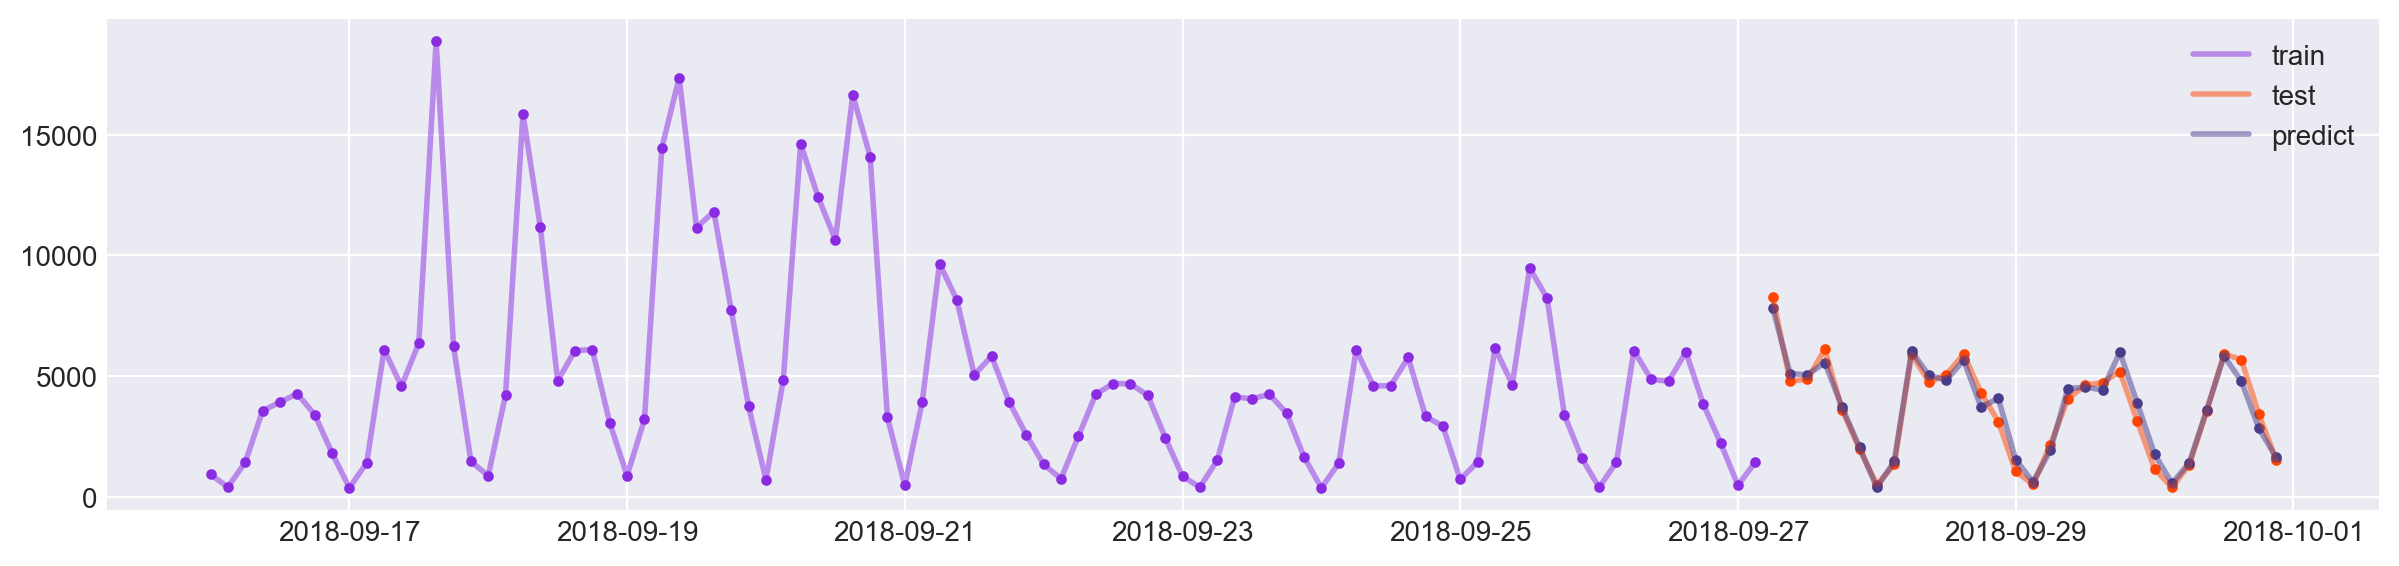

In [27]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [28]:
print(grid_search_results["params"])

{'l2_leaf_reg': 5}


In [29]:
del (
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

### Data Prep For LSTM

In [30]:
import tensorflow as tf


model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

data_x, data_y = seperate_target(df_feat, TARGET_COLUMN)

print(f"data_x shape after seperate_target {data_x.shape}")
print(f"data_y shape after seperate_target {data_y.shape}", end="\n\n")

scaler_x = StandardScaler()
scaler_x.fit(data_x)
data_x_np = scaler_x.transform(data_x)

scaler_y = StandardScaler()
scaler_y.fit(data_y)
data_y_np = scaler_y.transform(data_y)

print(f"data_x shape after StandardScaler {data_x_np.shape}")
print(f"data_y shape after StandardScaler {data_y_np.shape}", end="\n\n")

x_window, y_window = window_data(data_x_np, data_y_np, window_len=WINDOW_LEN)

print(f"x_window shape after Windowing {x_window.shape}")
print(f"y_window shape after Windowing {y_window.shape}", end="\n\n")

x_train_data, x_test_data = x_window[:-TEST_SIZE], x_window[-TEST_SIZE:]
y_train_data, y_test_data = y_window[:-TEST_SIZE], y_window[-TEST_SIZE:]

print(f"x_train_data shape after Test Train Split {x_train_data.shape}")
print(f"x_test_data  shape after Test Train Split {x_test_data.shape}")
print(f"y_train_data shape after Test Train Split {y_train_data.shape}")
print(f"y_test_data  shape after Test Train Split {y_test_data.shape}", end="\n\n")

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

dataframe shape (1825, 6)
dataframe shape after Feature Union (1822, 25)

data_x shape after seperate_target (1822, 24)
data_y shape after seperate_target (1822, 1)

data_x shape after StandardScaler (1822, 24)
data_y shape after StandardScaler (1822, 1)

x_window shape after Windowing (1799, 24, 24)
y_window shape after Windowing (1799, 1)

x_train_data shape after Test Train Split (1769, 24, 24)
x_test_data  shape after Test Train Split (30, 24, 24)
y_train_data shape after Test Train Split (1769, 1)
y_test_data  shape after Test Train Split (30, 1)



In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.models.Sequential(
    [
        LSTM(64, input_shape=x_window.shape[-2:], dropout=0.0, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=25,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/25
200/200 [==============================] - 7s 24ms/step - loss: 0.5455 - mae: 0.5586 - val_loss: 0.5978 - val_mae: 0.7197
Epoch 2/25
200/200 [==============================] - 4s 22ms/step - loss: 0.3937 - mae: 0.4589 - val_loss: 0.1516 - val_mae: 0.3159
Epoch 3/25
200/200 [==============================] - 4s 22ms/step - loss: 0.1962 - mae: 0.3284 - val_loss: 0.1064 - val_mae: 0.2581
Epoch 4/25
200/200 [==============================] - 4s 20ms/step - loss: 0.0846 - mae: 0.2070 - val_loss: 0.0733 - val_mae: 0.2060
Epoch 5/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0718 - mae: 0.1929 - val_loss: 0.0493 - val_mae: 0.1702
Epoch 6/25
200/200 [==============================] - 5s 24ms/step - loss: 0.0500 - mae: 0.1652 - val_loss: 0.0320 - val_mae: 0.1359
Epoch 7/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0668 - mae: 0.1912 - val_loss: 0.0375 - val_mae: 0.1563
Epoch 8/25
200/200 [==============================] - 4s 22ms/step - 

In [32]:
yhat_scaled = scaler_y.inverse_transform(yhat)
y_test_data_scaled = scaler_y.inverse_transform(y_test_data)
y_train_data_scaled = scaler_y.inverse_transform(y_train_data)


print(f"yhat_scaled shape {yhat_scaled.shape} {y_test_data_scaled.shape}")
resultsDict[model_name] = evaluate(y_test_data_scaled, yhat_scaled)

yhat_scaled shape (30, 1) (30, 1)


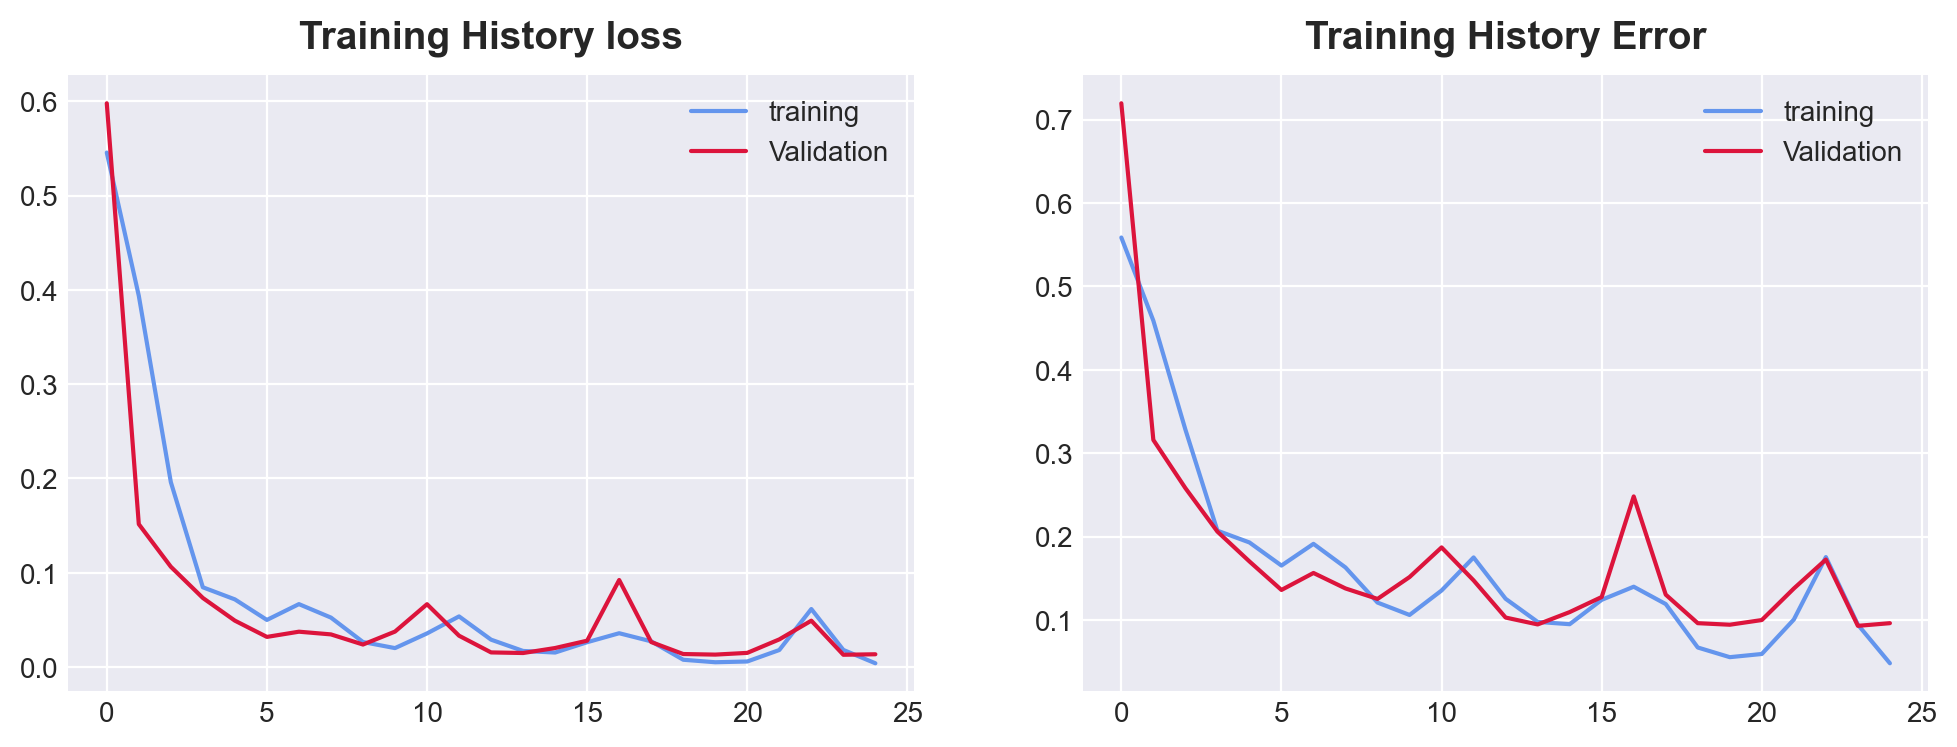

In [33]:
plot_tf_training_history(training_history)

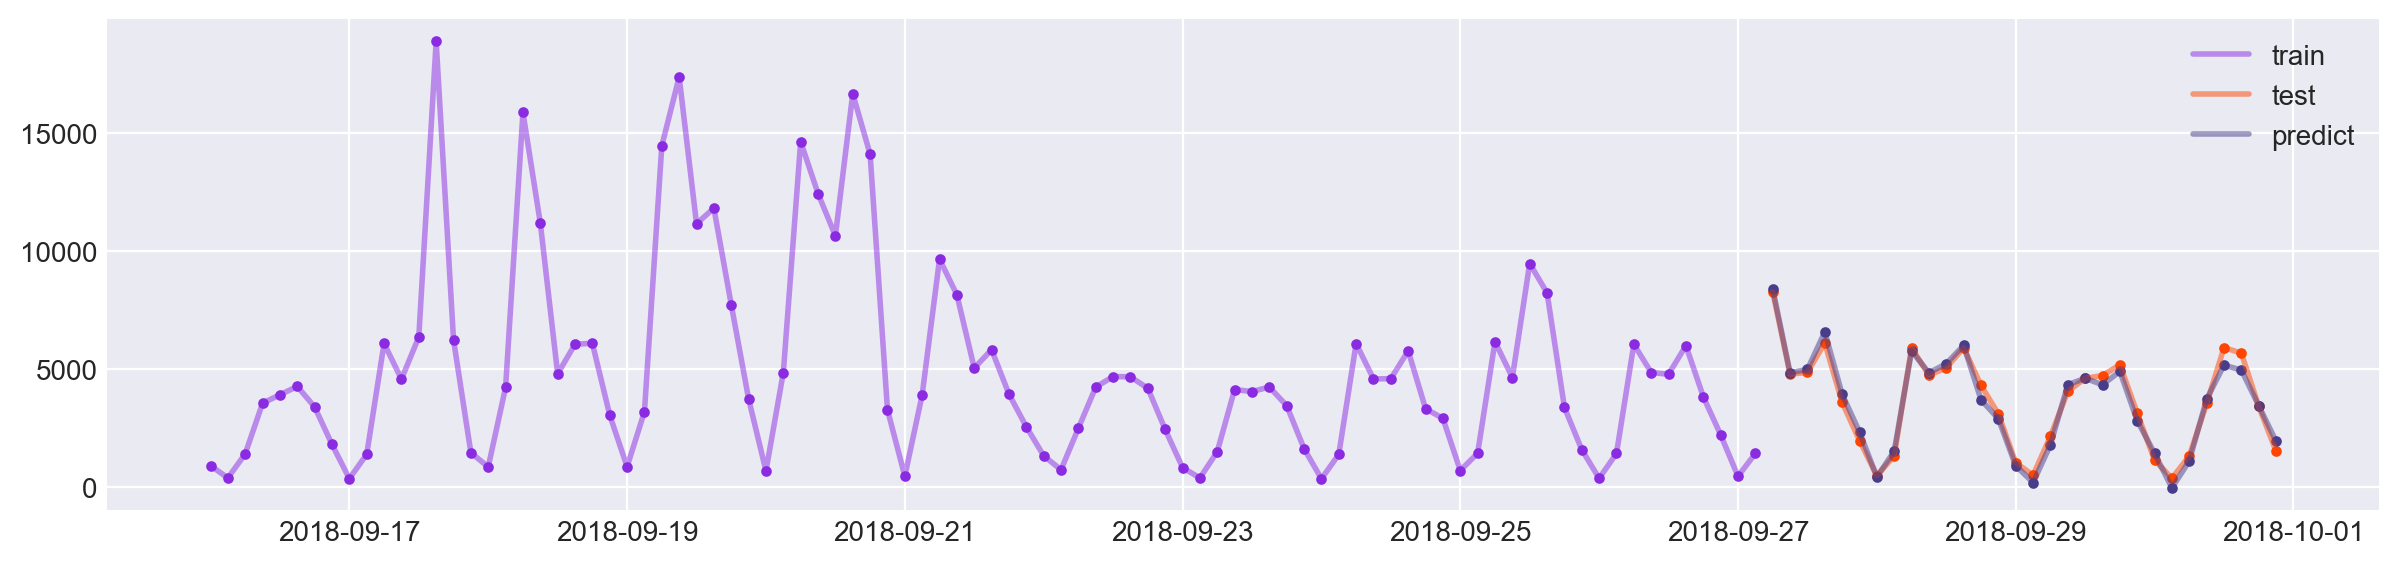

In [34]:
y_hat_df = pd.DataFrame(
    yhat_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_test_data_df = pd.DataFrame(
    y_test_data_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_train_data_df = pd.DataFrame(
    y_train_data_scaled,
    index=data_y.index[WINDOW_LEN - 1 : -TEST_SIZE],
    columns=["TARGET_COLUMN"],
)

show_series(
    [y_train_data_df[-90:], y_test_data_df, y_hat_df],
    labels=["train", "test", "predict"],
)

In [35]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,1396.049206,1113.972796,1116.305901,321.423168,364.297039,367.750184,335.122901,271.246554
rmse,1706.581377,1350.210164,1355.405914,475.423199,532.617896,510.745126,428.406093,329.343512
mape,0.769011,0.606092,0.573993,0.121890,0.124201,0.139486,0.133822,0.141705
r2,0.285402,0.552688,0.549239,0.944541,0.930395,0.935995,0.954968,0.973386


In [36]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,1396.049206,1706.581377,0.769011,0.285402
BayesianRidge,1113.972796,1350.210164,0.606092,0.552688
LassoCV,1116.305901,1355.405914,0.573993,0.549239
RandomForestRegressor,321.423168,475.423199,0.121890,0.944541
XGBRegressor,364.297039,532.617896,0.124201,0.930395
LGBMRegressor,367.750184,510.745126,0.139486,0.935995
CatBoostRegressor,335.122901,428.406093,0.133822,0.954968
LSTM_Dense,271.246554,329.343512,0.141705,0.973386


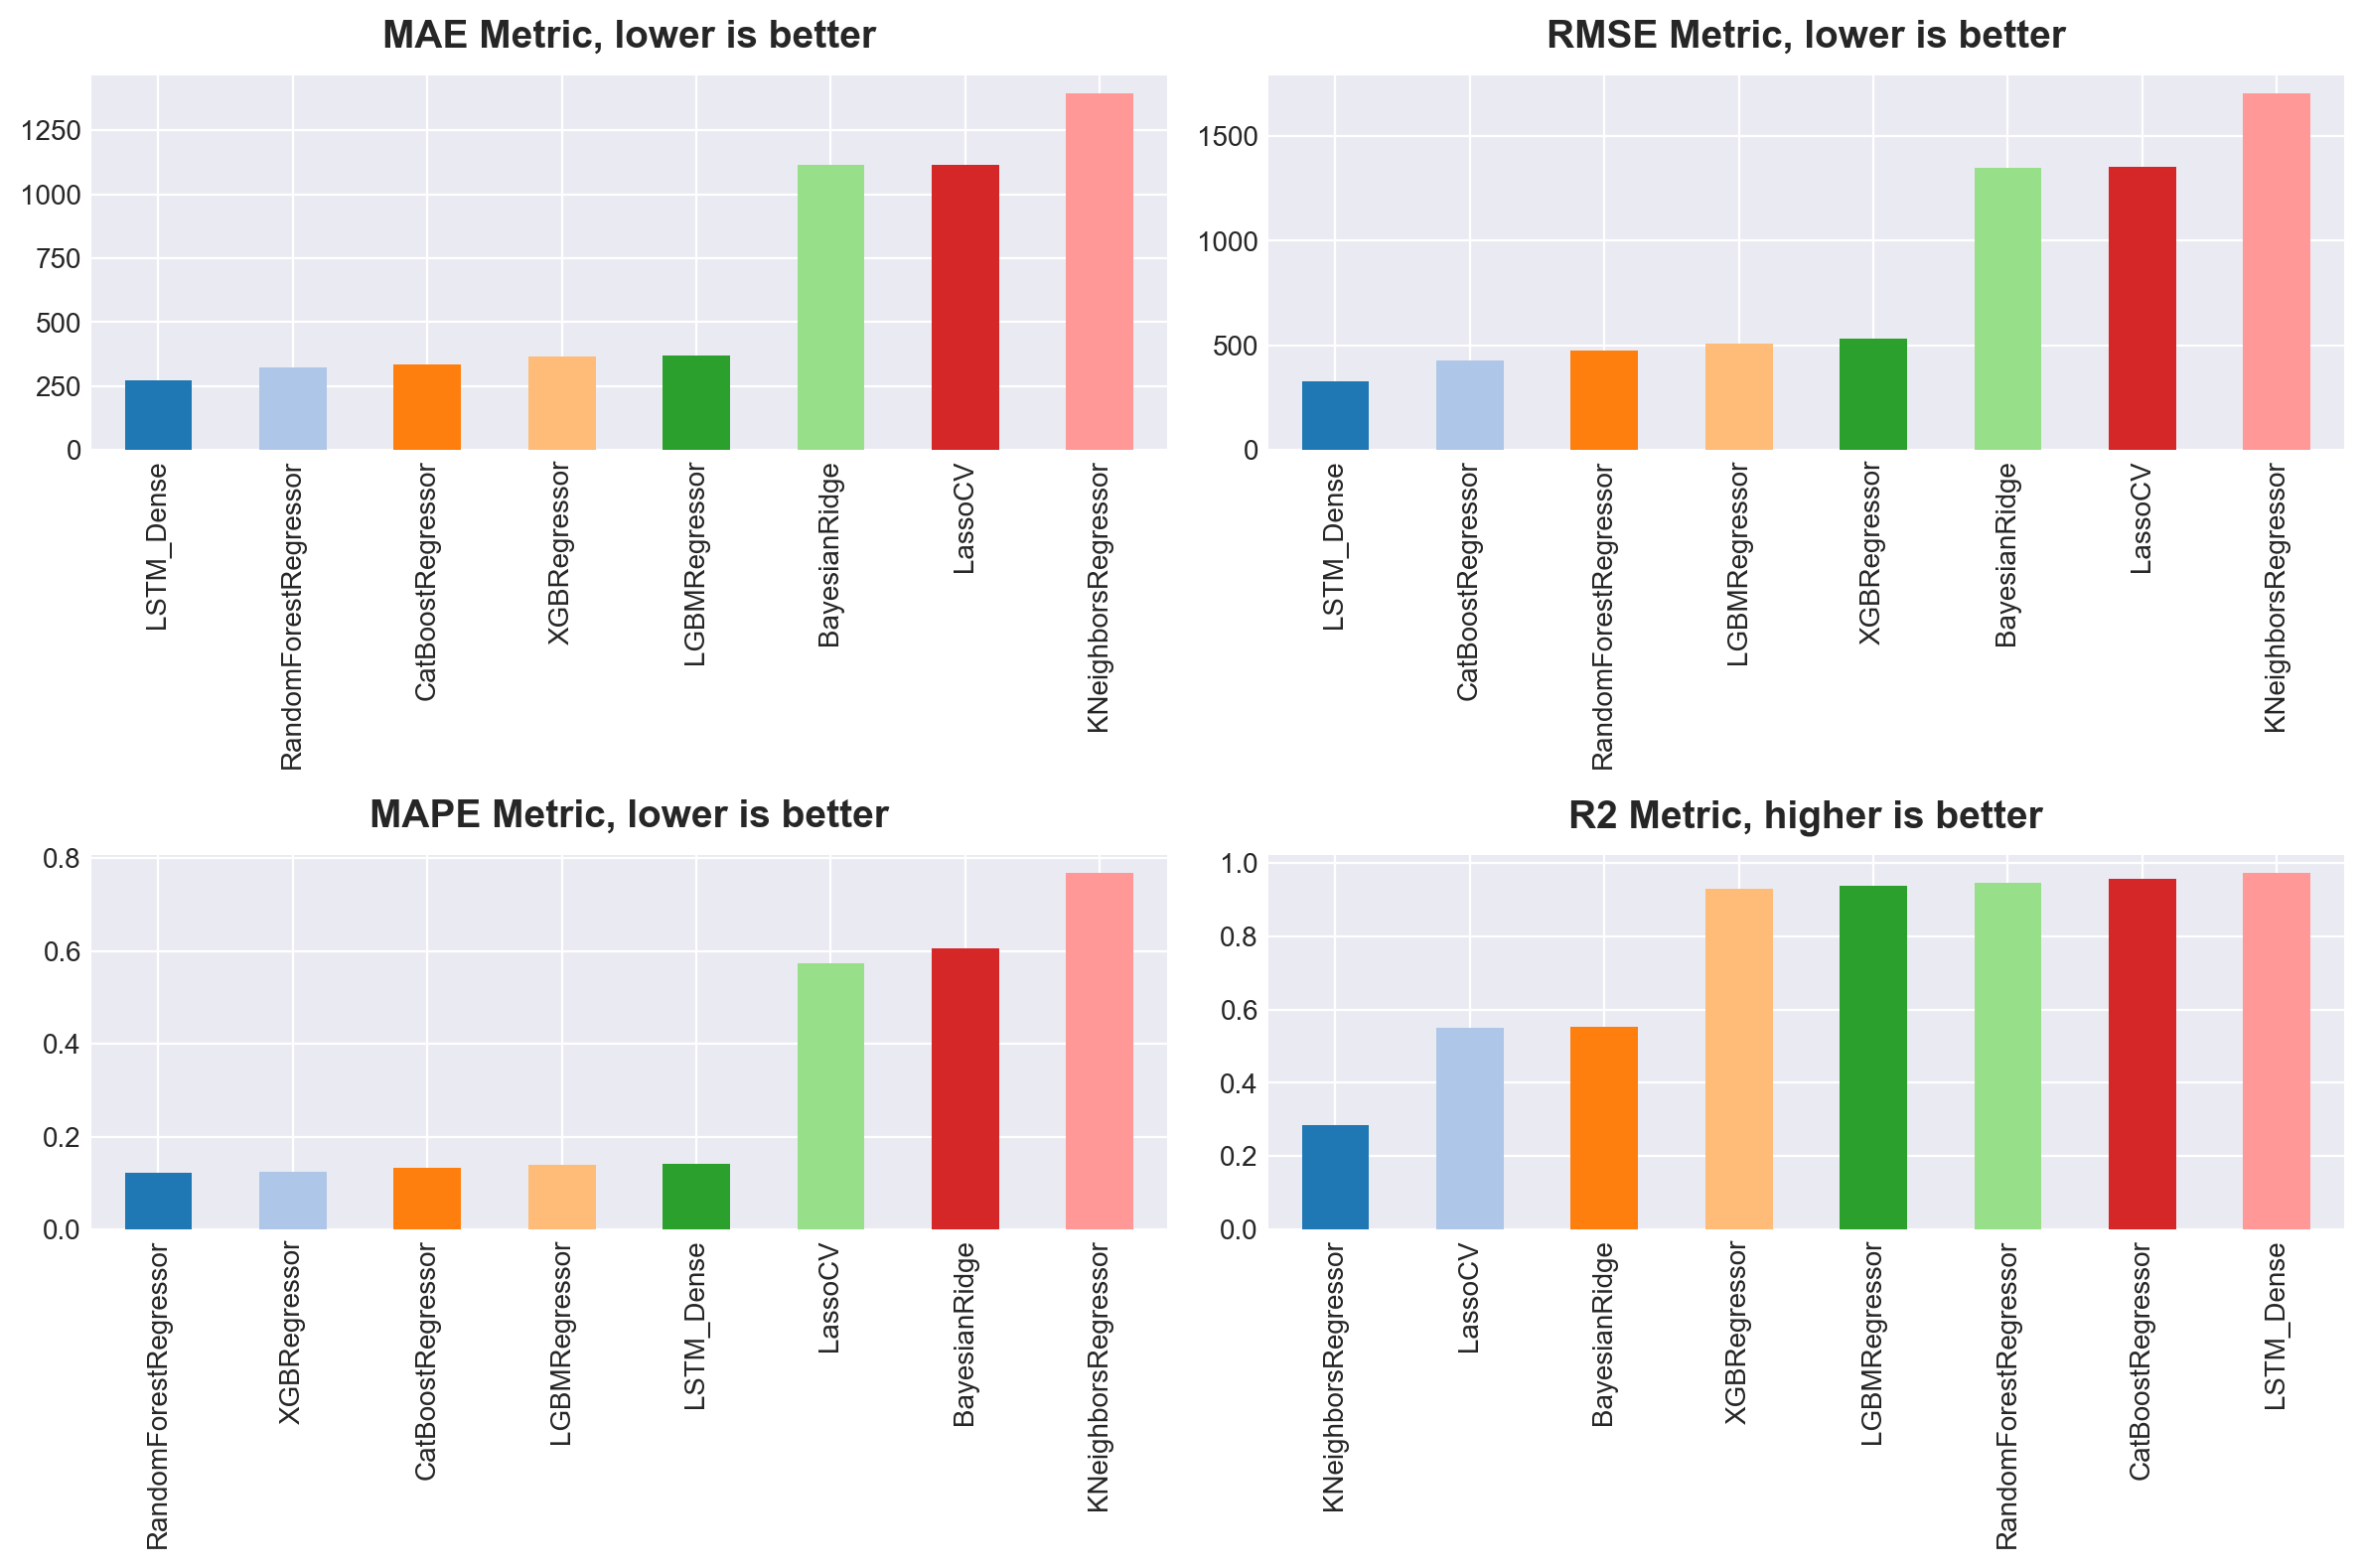

In [37]:
plot_metrics(resultsDF)

### Saving results

In [38]:
resultsDF_T = resultsDF.T.copy(deep=True)
resultsDF_T["Dataset"] = "Traffic"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"

if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Traffic"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Traffic"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)